In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import boto3
import io
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
outcomes = [
    'Connected_Youth',
    'CnctAdult_w23',
    'Homeless_w23',
    'SubAbuse_w23',
    'Incarc_w23',
    'Children_NoMarriage_w23'

]

predictor_groups = {
    'Core': ['Sex'] + ['White_Only', 'race_other'],
    'Disability': ['DiagDis'],
    'RemovalReason': ['RR_neglect', 'RR_abuse', 'RR_other'],
    'Placement': ['PlacementType', 'PlacementInstability', 'MonthsInCare'],
    'EarlyIndicators': ['SubAbuse_w1', 'CnctAdult_w1']
}

In [3]:
predictor_columns = ['Sex', 'White_Only', 'race_other', 'DiagDis', 'RR_neglect', 'RR_abuse', 'RR_other', 'PlacementType', 'PlacementInstability', 'MonthsInCare', 'SubAbuse_w1', 'CnctAdult_w1']

In [4]:
wave_service_afcars = pd.read_csv('wave_service_afcars_final.csv')
significant_model_results = pd.read_csv('significant_model_results.csv')

## Sig predictors & outcomes associated

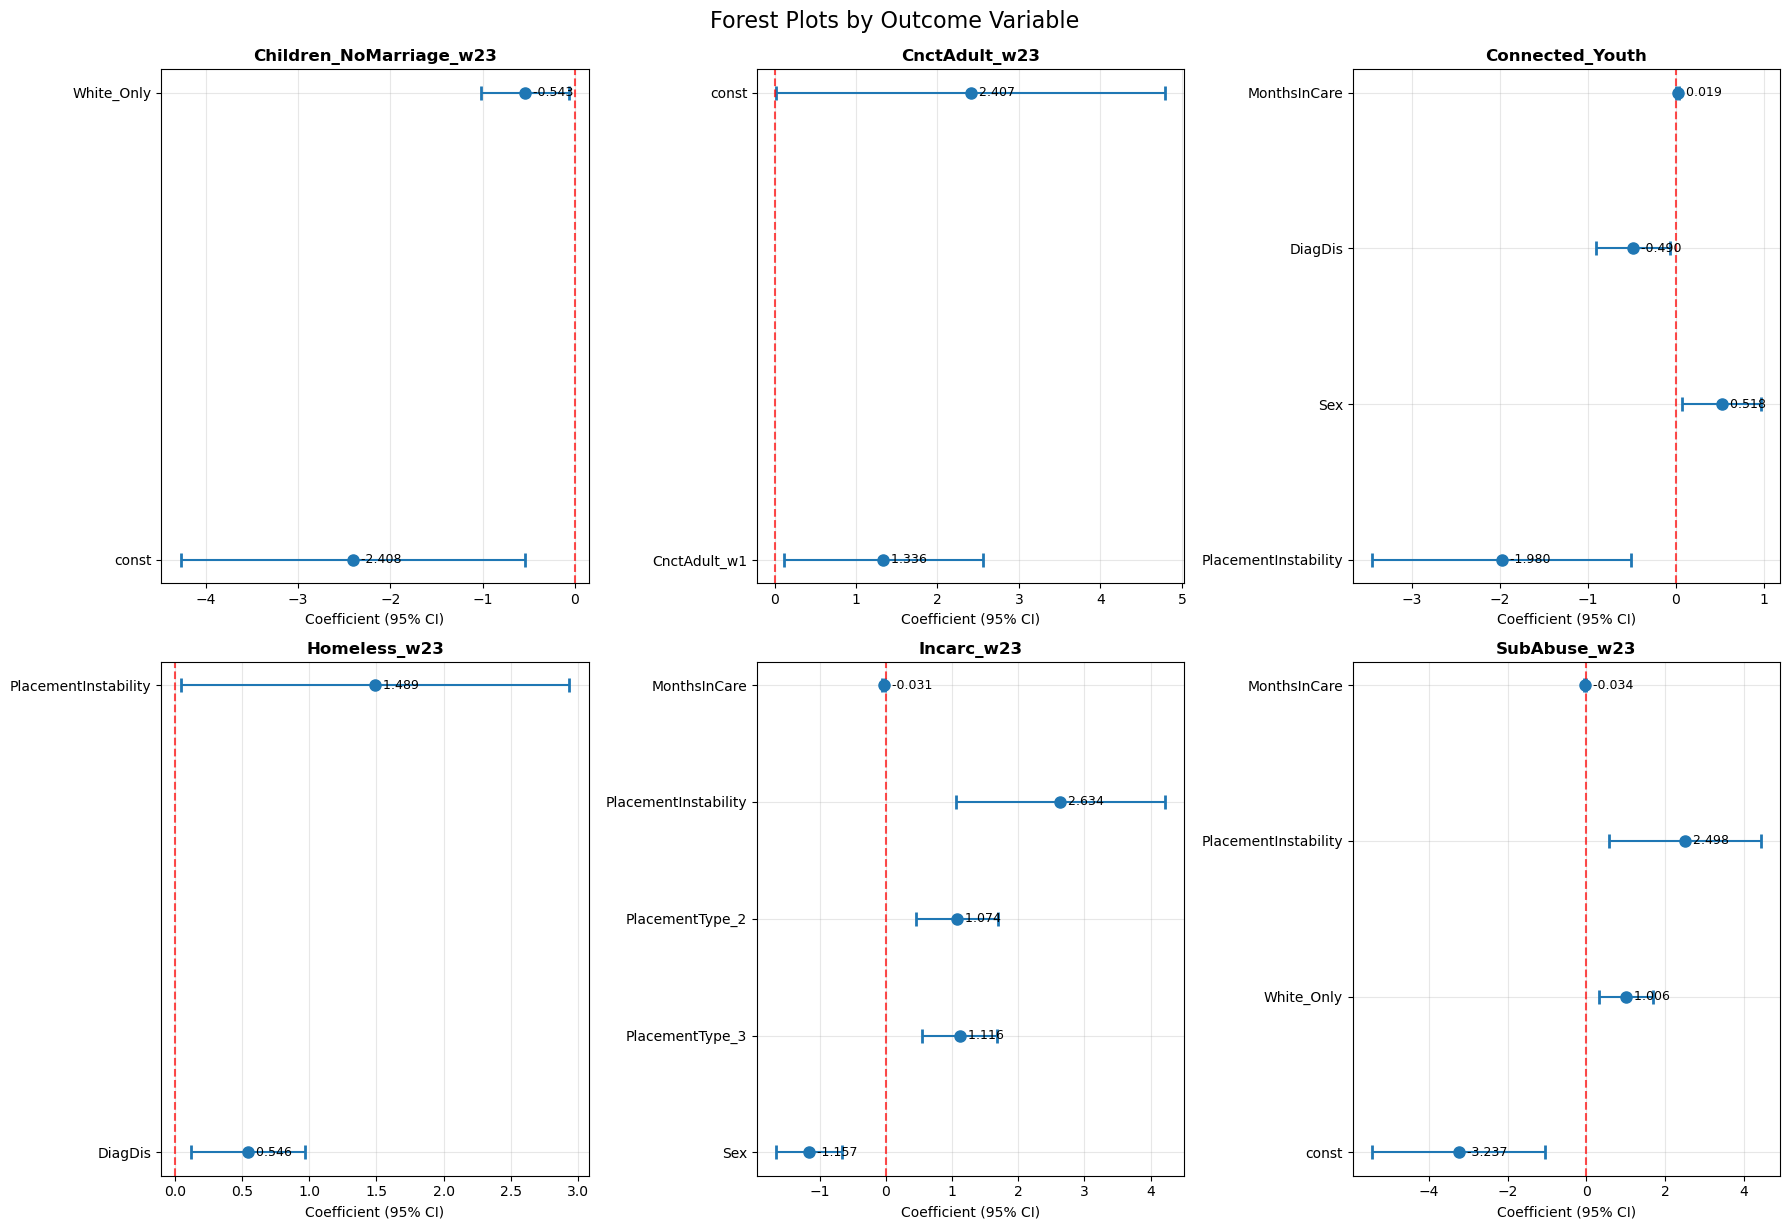

In [5]:
# Cell 3: Forest Plot by Outcome
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

outcomes = significant_model_results['Outcome'].unique()
for i, outcome in enumerate(outcomes):
    if i < len(axes):
        outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
        
        y_pos = range(len(outcome_data))
        coeffs = outcome_data['Coefficient']
        ci_lower = outcome_data['CI Lower']
        ci_upper = outcome_data['CI Upper']
        
        # Create error bars
        axes[i].errorbar(coeffs, y_pos,
                        xerr=[coeffs - ci_lower, ci_upper - coeffs],
                        fmt='o', capsize=5, capthick=2, markersize=8)
        
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(outcome_data['Variable'], fontsize=10)
        axes[i].set_xlabel('Coefficient (95% CI)')
        axes[i].set_title(f'{outcome}', fontsize=12, fontweight='bold')
        axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes[i].grid(True, alpha=0.3)
        
        # Add coefficient values as text
        for j, (coef, var) in enumerate(zip(coeffs, outcome_data['Variable'])):
            axes[i].text(coef, j, f'  {coef:.3f}', va='center', fontsize=9)

# Hide empty subplots
for i in range(len(outcomes), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Forest Plots by Outcome Variable', fontsize=16, y=1.02)
plt.savefig('Report/all_visual_data_forest_plot.png', bbox_inches='tight', dpi=300)
plt.show()

## Risk vs. positive factors

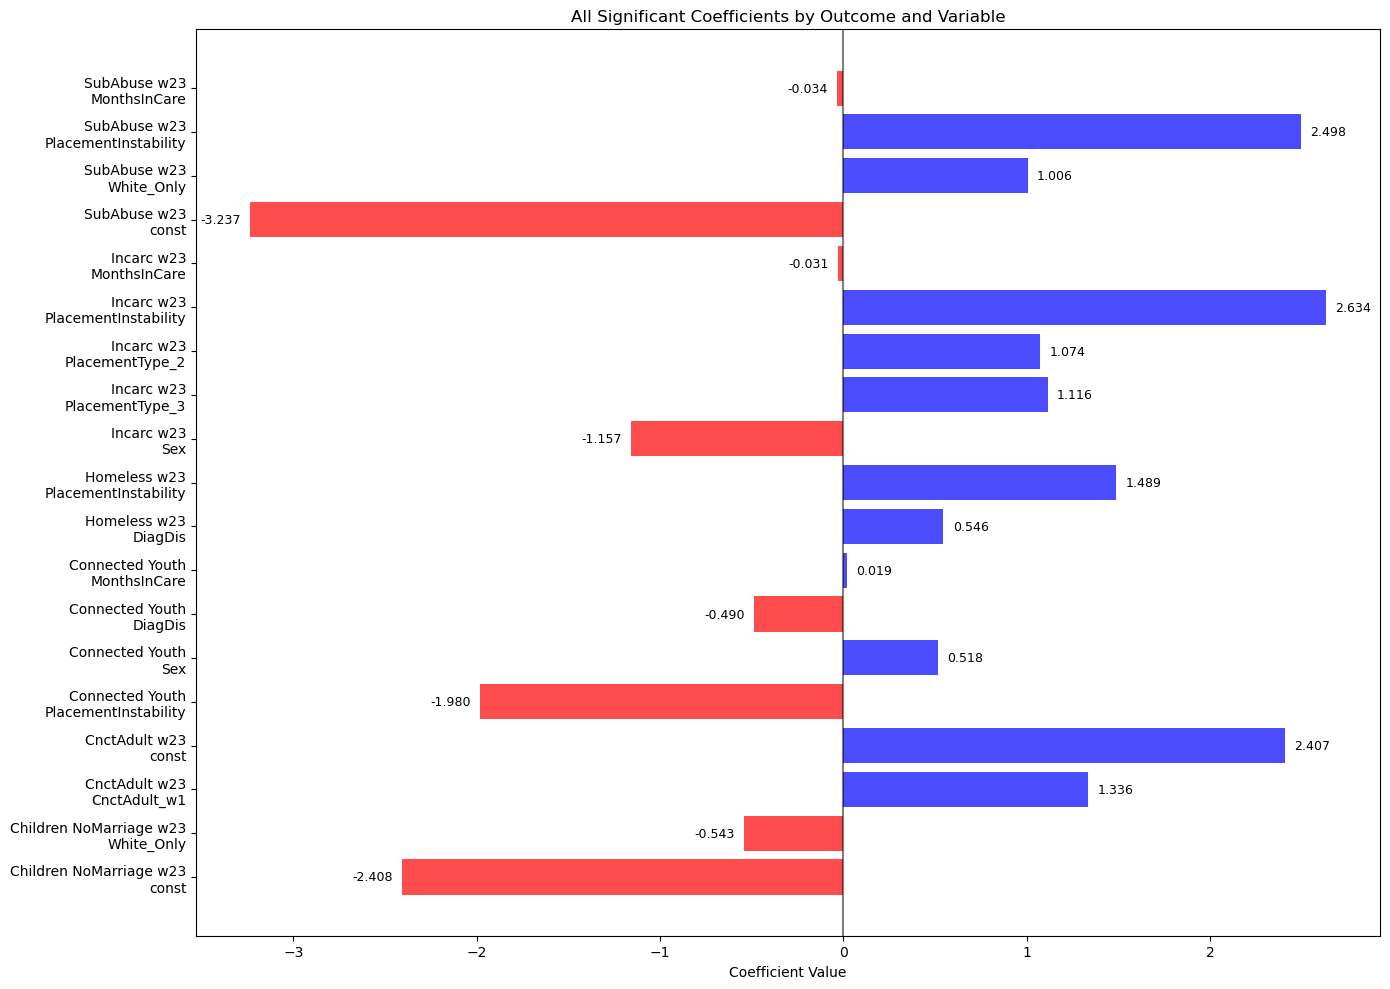

In [6]:
# Cell 5: Coefficient Magnitude Analysis
plt.figure(figsize=(14, 10))

# Create horizontal bar plot of all coefficients
y_pos = range(len(significant_model_results))
colors = ['red' if x < 0 else 'blue' for x in significant_model_results['Coefficient']]

plt.barh(y_pos, significant_model_results['Coefficient'], color=colors, alpha=0.7)

# Create labels with outcome and variable
labels = [f"{row['Outcome'].replace('_', ' ')}\n{row['Variable']}" 
          for _, row in significant_model_results.iterrows()]

plt.yticks(y_pos, labels, fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('All Significant Coefficients by Outcome and Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add coefficient values on bars
for i, (coef, outcome) in enumerate(zip(significant_model_results['Coefficient'], 
                                       significant_model_results['Outcome'])):
    offset = 0.05 if coef >= 0 else -0.05
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('Report/all_sig_data_bar.png', bbox_inches='tight', dpi=300)
plt.show()

## How many times it is significant

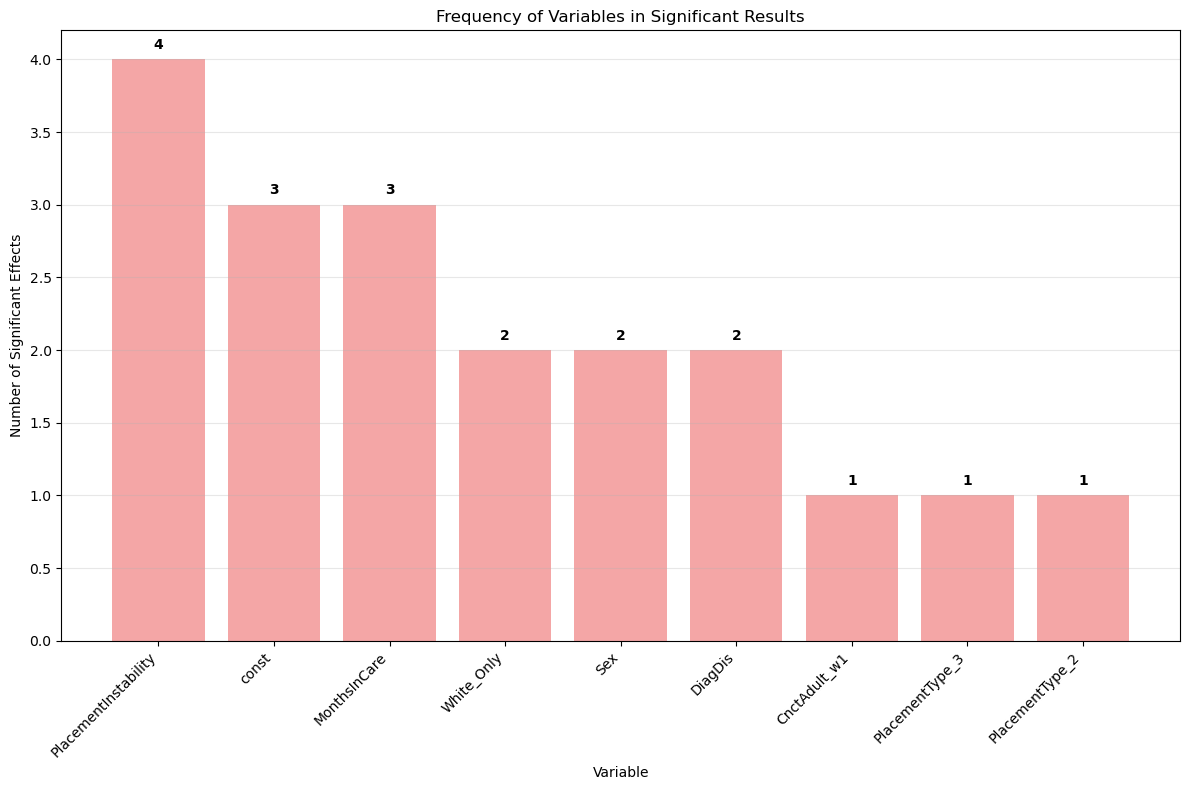

In [7]:
# Cell 6: Variable Frequency Analysis
plt.figure(figsize=(12, 8))

# Count how often each variable appears as significant
variable_counts = significant_model_results['Variable'].value_counts()

plt.bar(range(len(variable_counts)), variable_counts.values, alpha=0.7, color='lightcoral')
plt.xticks(range(len(variable_counts)), variable_counts.index, rotation=45, ha='right')
plt.ylabel('Number of Significant Effects')
plt.xlabel('Variable')
plt.title('Frequency of Variables in Significant Results')
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate(variable_counts.values):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('Report/frequency_of_variables_in_significant_results.png', bbox_inches='tight', dpi=300)
plt.show()

## Descriptive

In [8]:
# Generate descriptive stats
descriptive_stats = wave_service_afcars.describe(include='all').T

# Add a column for the column name
descriptive_stats = descriptive_stats.reset_index().rename(columns={'index': 'column_name'})


## Summery Table

In [9]:
# Cell 10: Summary Tables and Key Insights
print("="*80)
print("SUMMARY OF SIGNIFICANT RESULTS")
print("="*80)

print(f"\nTotal significant effects found: {len(significant_model_results)}")
print(f"Outcomes analyzed: {len(significant_model_results['Outcome'].unique())}")
print(f"Unique variables with significant effects: {len(significant_model_results['Variable'].unique())}")

print("\n" + "="*50)
print("STRONGEST EFFECTS (by absolute coefficient)")
print("="*50)
strongest_effects = significant_model_results.reindex(
    significant_model_results['Coefficient'].abs().sort_values(ascending=False).index
).head(5)

for _, row in strongest_effects.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"\n{row['Variable']} → {row['Outcome']}")
    print(f"  Coefficient: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")
    print(f"  Effect: {row['Variable']} {direction} {row['Outcome']} by {abs(row['Coefficient']):.3f} units")

print("\n" + "="*50)
print("MOST SIGNIFICANT EFFECTS (by p-value)")
print("="*50)
most_significant = significant_model_results.nsmallest(5, 'P-Value')

for _, row in most_significant.iterrows():
    print(f"\n{row['Variable']} → {row['Outcome']} (p={row['P-Value']:.6f})")
    print(f"  Coefficient: {row['Coefficient']:.3f}")
    print(f"  95% CI: [{row['CI Lower']:.3f}, {row['CI Upper']:.3f}]")

print("\n" + "="*50)
print("EFFECTS BY OUTCOME")
print("="*50)
for outcome in significant_model_results['Outcome'].unique():
    outcome_data = significant_model_results[significant_model_results['Outcome'] == outcome]
    print(f"\n{outcome}: {len(outcome_data)} significant variables")
    for _, row in outcome_data.iterrows():
        direction = "↑" if row['Coefficient'] > 0 else "↓"
        print(f"  {direction} {row['Variable']}: {row['Coefficient']:.3f} (p={row['P-Value']:.4f})")

SUMMARY OF SIGNIFICANT RESULTS

Total significant effects found: 19
Outcomes analyzed: 6
Unique variables with significant effects: 9

STRONGEST EFFECTS (by absolute coefficient)

const → SubAbuse_w23
  Coefficient: -3.237 (p=0.0039)
  Effect: const decreases SubAbuse_w23 by 3.237 units

PlacementInstability → Incarc_w23
  Coefficient: 2.634 (p=0.0011)
  Effect: PlacementInstability increases Incarc_w23 by 2.634 units

PlacementInstability → SubAbuse_w23
  Coefficient: 2.498 (p=0.0108)
  Effect: PlacementInstability increases SubAbuse_w23 by 2.498 units

const → Children_NoMarriage_w23
  Coefficient: -2.408 (p=0.0113)
  Effect: const decreases Children_NoMarriage_w23 by 2.408 units

const → CnctAdult_w23
  Coefficient: 2.407 (p=0.0477)
  Effect: const increases CnctAdult_w23 by 2.407 units

MOST SIGNIFICANT EFFECTS (by p-value)

Sex → Incarc_w23 (p=0.000004)
  Coefficient: -1.157
  95% CI: [-1.650, -0.664]

PlacementType_3 → Incarc_w23 (p=0.000104)
  Coefficient: 1.116
  95% CI: [0.553

## Frequency Breakdown

In [10]:
# Cell 1: Basic frequency breakdown for each outcome
print("="*60)
print("OUTCOME FREQUENCY BREAKDOWN")
print("="*60)

for outcome in outcomes:
    if outcome in wave_service_afcars.columns:
        print(f"\n{outcome}:")
        freq = wave_service_afcars[outcome].value_counts().sort_index()
        print(freq)
        print(f"Total valid responses: {freq.sum()}")
        print(f"Missing values: {wave_service_afcars[outcome].isna().sum()}")
    else:
        print(f"\n{outcome}: Column not found in dataset")


OUTCOME FREQUENCY BREAKDOWN

Children_NoMarriage_w23:
0.0    550
1.0    159
Name: Children_NoMarriage_w23, dtype: int64
Total valid responses: 709
Missing values: 11

CnctAdult_w23:
0.0     41
1.0    678
Name: CnctAdult_w23, dtype: int64
Total valid responses: 719
Missing values: 1

Connected_Youth:
0.0    252
1.0    464
Name: Connected_Youth, dtype: int64
Total valid responses: 716
Missing values: 4

Homeless_w23:
0.0    508
1.0    211
Name: Homeless_w23, dtype: int64
Total valid responses: 719
Missing values: 1

Incarc_w23:
0.0    462
1.0    256
Name: Incarc_w23, dtype: int64
Total valid responses: 718
Missing values: 2

SubAbuse_w23:
0.0    584
1.0    133
Name: SubAbuse_w23, dtype: int64
Total valid responses: 717
Missing values: 3


## Bar Chart of Outcomes

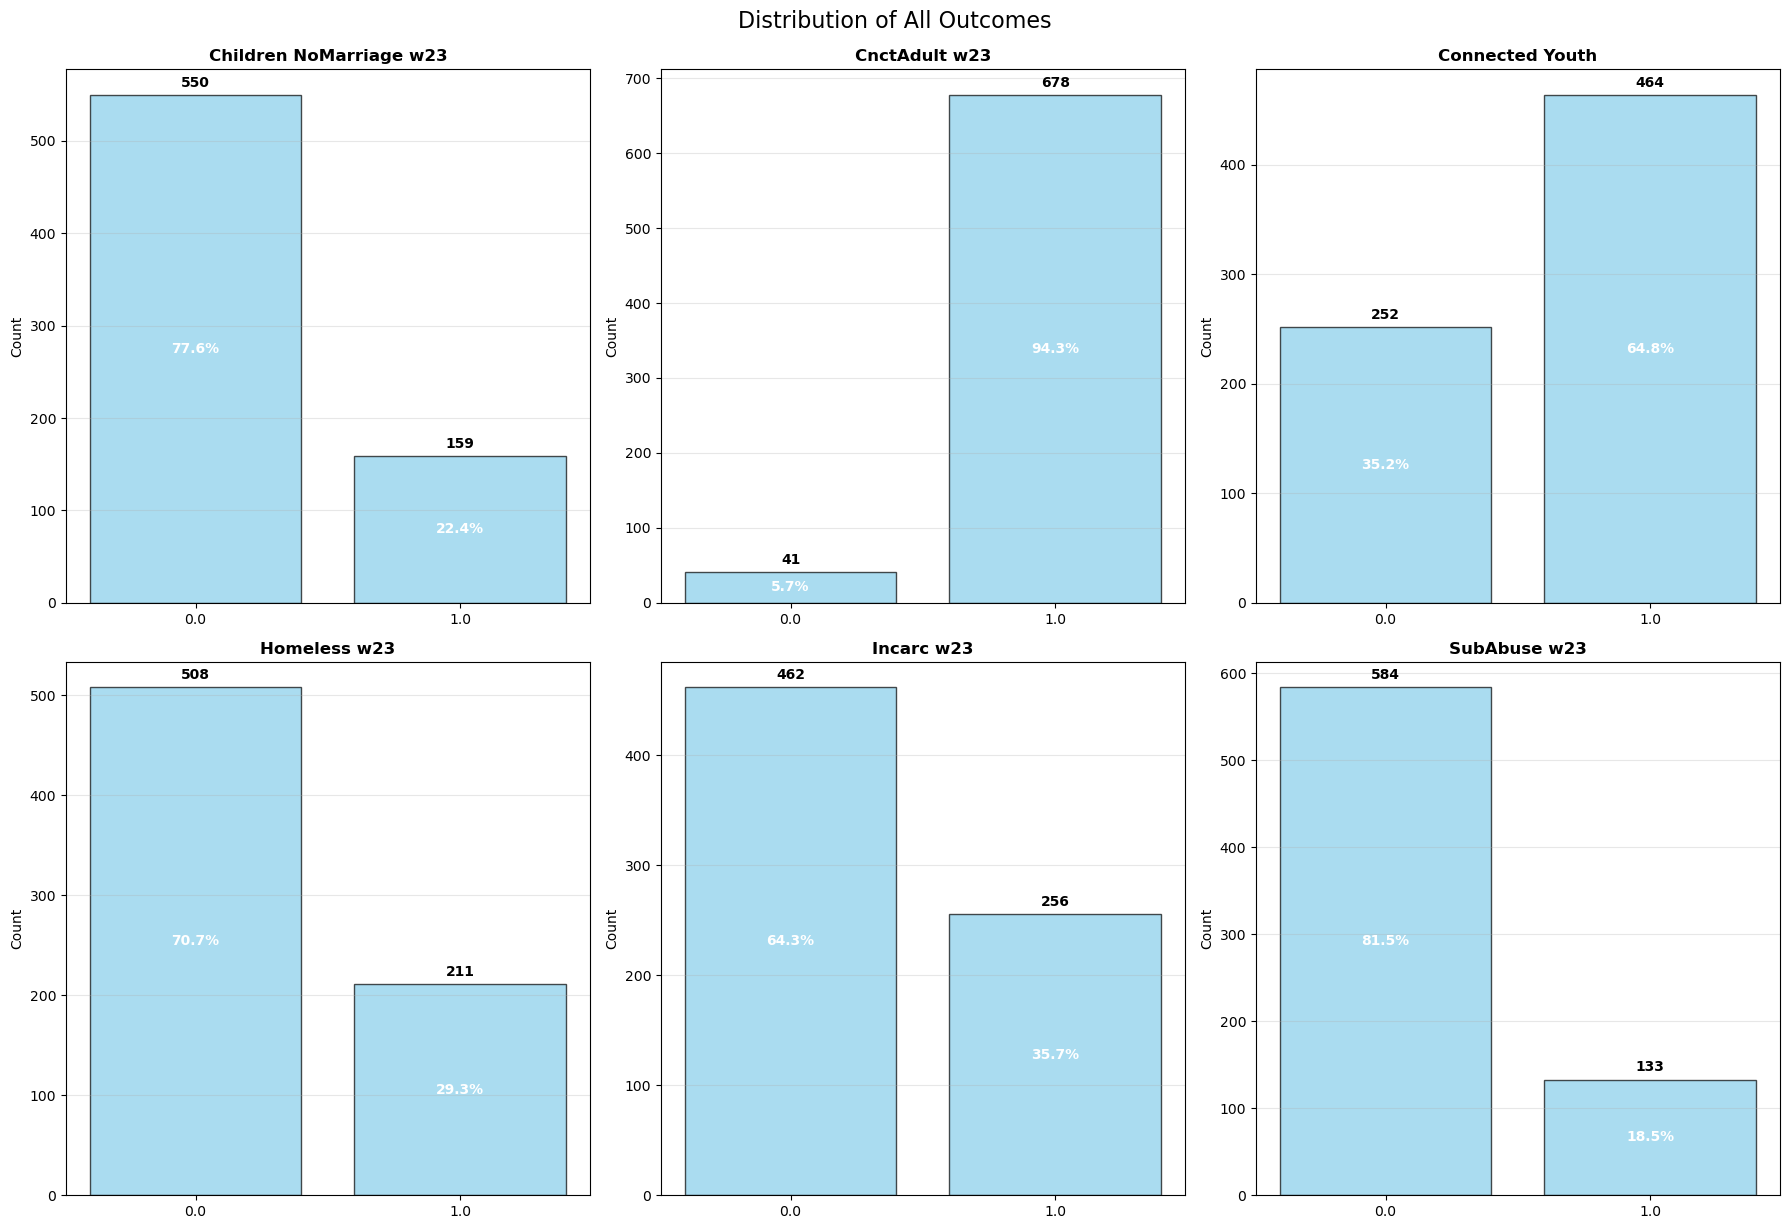

In [11]:
# Cell 2: Bar charts for each outcome separately
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, outcome in enumerate(outcomes):
    if outcome in wave_service_afcars.columns:
        # Get value counts
        counts = wave_service_afcars[outcome].value_counts().sort_index()
        
        # Create bar chart
        axes[i].bar(range(len(counts)), counts.values, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index)
        axes[i].set_title(f'{outcome.replace("_", " ")}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for j, count in enumerate(counts.values):
            axes[i].text(j, count + max(counts.values) * 0.01, str(count), 
                        ha='center', va='bottom', fontweight='bold')
        
        # Add percentage labels
        total = counts.sum()
        for j, count in enumerate(counts.values):
            pct = (count/total) * 100
            axes[i].text(j, count/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'{outcome}\nNot Found', transform=axes[i].transAxes, 
                    ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

plt.tight_layout()
plt.suptitle('Distribution of All Outcomes', fontsize=16, y=1.02)
plt.savefig('Report/each_outcome_bar_chart.png', bbox_inches='tight', dpi=300)
plt.show()

## bar chart of predictors

In [12]:
predictors = ['Sex', 'White_Only', 'race_other','DiagDis', 'RR_neglect', 'RR_abuse', 'RR_other',
'PlacementType','SubAbuse_w1', 'CnctAdult_w1']

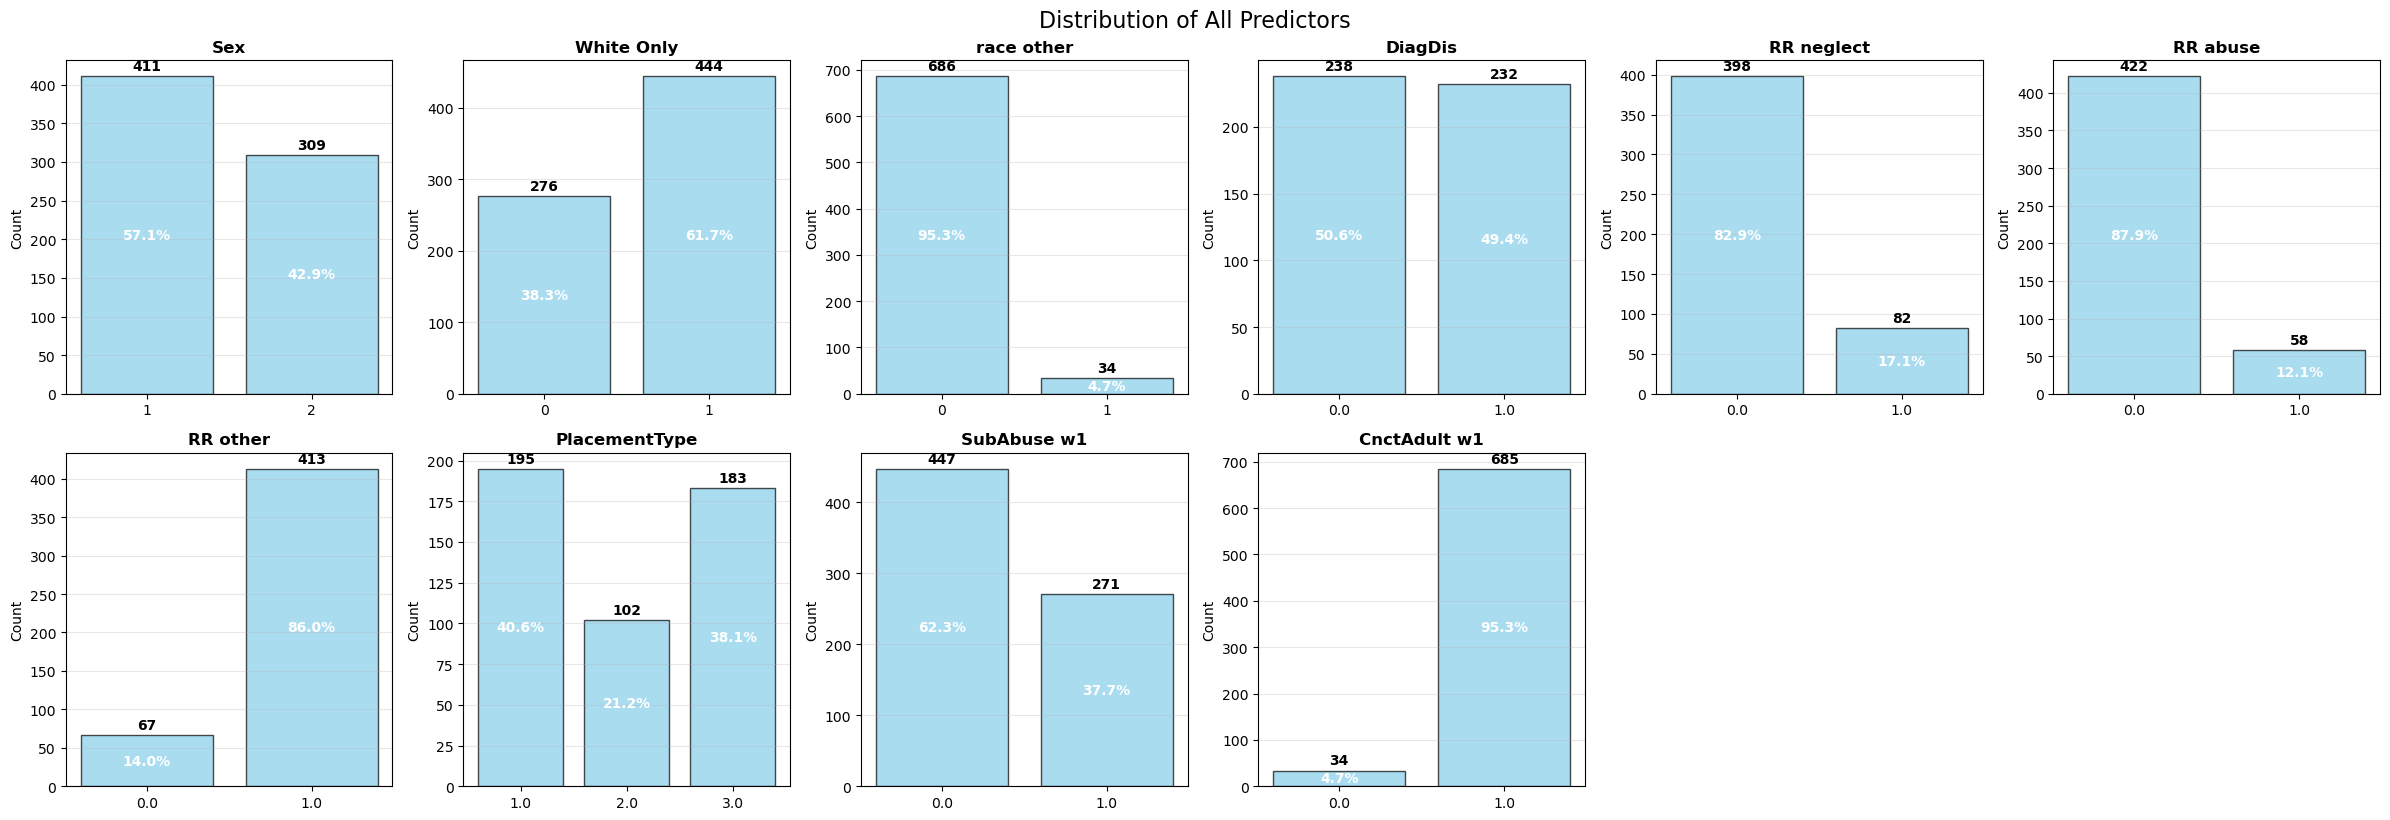

In [13]:
# Bar charts for each predictor in the predictors list
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
axes = axes.flatten()

for i, predictor in enumerate(predictors):
    if predictor in wave_service_afcars.columns:
        counts = wave_service_afcars[predictor].value_counts().sort_index()
        axes[i].bar(range(len(counts)), counts.values, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_xticks(range(len(counts)))
        axes[i].set_xticklabels(counts.index)
        axes[i].set_title(f'{predictor.replace("_", " ")}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Count')
        axes[i].grid(True, alpha=0.3, axis='y')
        for j, count in enumerate(counts.values):
            axes[i].text(j, count + max(counts.values) * 0.01, str(count), 
                        ha='center', va='bottom', fontweight='bold')
        total = counts.sum()
        for j, count in enumerate(counts.values):
            pct = (count/total) * 100
            axes[i].text(j, count/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'{predictor}\nNot Found', transform=axes[i].transAxes, 
                    ha='center', va='center', fontsize=12)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide any unused subplots
for j in range(len(predictors), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Distribution of All Predictors', fontsize=16, y=1.02)
plt.savefig('Report/each_predictor_bar_chart.png', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
# Check if our target columns exist 
target_columns = ['PlacementInstability', 'MonthsInCare']
existing_columns = [col for col in target_columns if col in wave_service_afcars.columns]
print(f"Target columns found: {existing_columns}")

Target columns found: ['PlacementInstability', 'MonthsInCare']



PlacementInstability: 480 non-null values
Range: 1.0 to 28.0

MonthsInCare: 480 non-null values
Range: 0.164271047 to 110.5215606


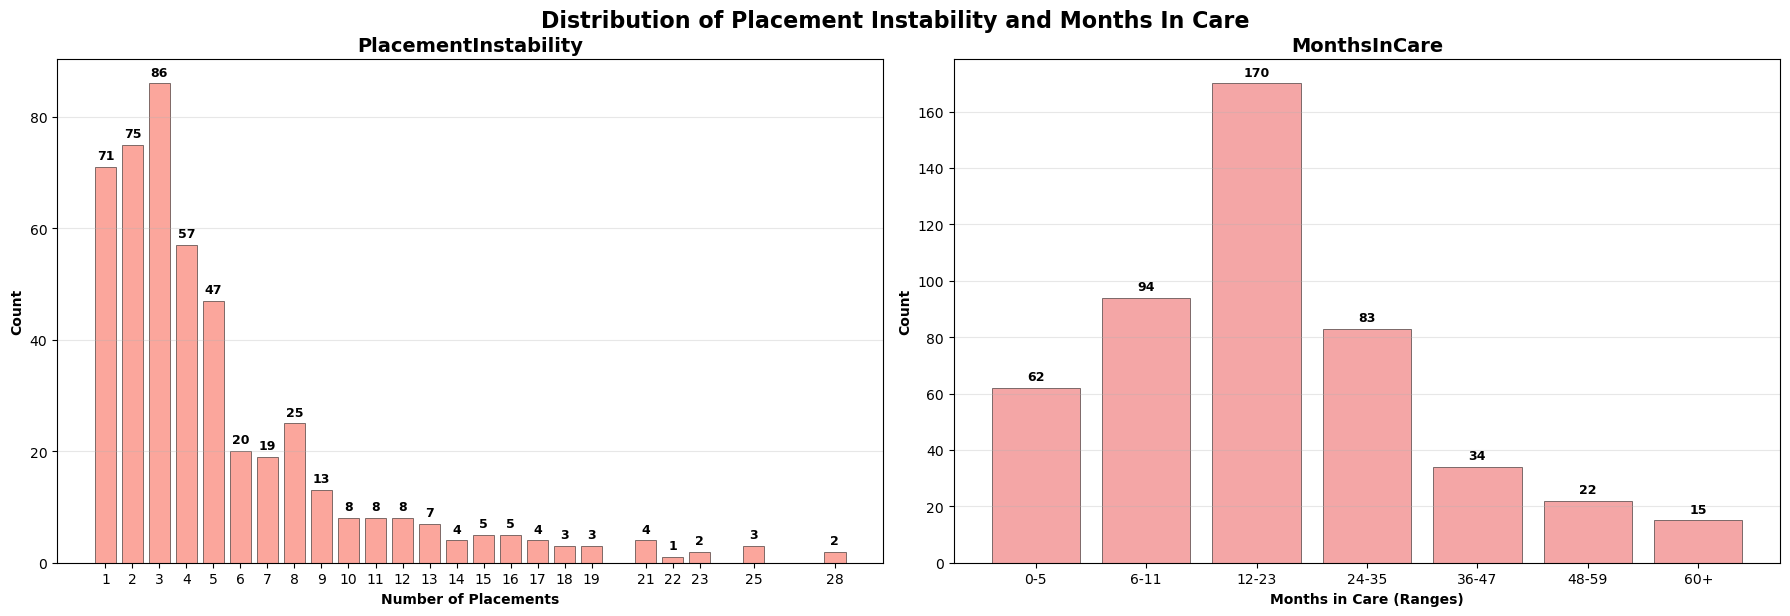

In [15]:
# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
# Chart 1: PlacementInstability
if 'PlacementInstability' in wave_service_afcars.columns:
        # Remove any missing values and get counts
        placement_data = wave_service_afcars['PlacementInstability'].dropna()
        print(f"\nPlacementInstability: {len(placement_data)} non-null values")
        print(f"Range: {placement_data.min()} to {placement_data.max()}")
        
        if len(placement_data) > 0:
            counts = placement_data.value_counts().sort_index()
            x_vals = counts.index
            y_vals = counts.values
            
            # Create bars
            bars1 = axes[0].bar(x_vals, y_vals, alpha=0.7, color='salmon', 
                               edgecolor='black', linewidth=0.5)
            
            axes[0].set_title('PlacementInstability', fontsize=14, fontweight='bold')
            axes[0].set_ylabel('Count', fontweight='bold')
            axes[0].set_xlabel('Number of Placements', fontweight='bold')
            axes[0].grid(True, alpha=0.3, axis='y')
            
            # Add count labels above bars
            for bar, count in zip(bars1, y_vals):
                height = bar.get_height()
                axes[0].text(bar.get_x() + bar.get_width()/2., height + max(y_vals) * 0.01,
                            f'{int(count)}', ha='center', va='bottom', 
                            fontweight='bold', fontsize=9)
            
            # Set x-ticks
            axes[0].set_xticks(x_vals)
        else:
            axes[0].text(0.5, 0.5, 'No data available', ha='center', va='center', 
                        transform=axes[0].transAxes, fontsize=12)
else:
            axes[0].text(0.5, 0.5, 'PlacementInstability\ncolumn not found', 
                    ha='center', va='center', transform=axes[0].transAxes, fontsize=12)
            axes[0].set_title('PlacementInstability', fontsize=14, fontweight='bold')
    
    # Chart 2: MonthsInCare
if 'MonthsInCare' in wave_service_afcars.columns:
        # Remove any missing values
        months_data = wave_service_afcars['MonthsInCare'].dropna()
        print(f"\nMonthsInCare: {len(months_data)} non-null values")
        print(f"Range: {months_data.min()} to {months_data.max()}")
        
        if len(months_data) > 0:
            # Create smart bins based on data range
            max_months = months_data.max()
            min_months = months_data.min()
            
            if max_months <= 36:
                # For shorter stays, use smaller bins
                bins = [0, 6, 12, 18, 24, 30, 36]
                labels = ['0-5', '6-11', '12-17', '18-23', '24-29', '30-35']
            else:
                # For longer stays, use larger bins
                bins = [0, 6, 12, 24, 36, 48, 60, float('inf')]
                labels = ['0-5', '6-11', '12-23', '24-35', '36-47', '48-59', '60+']
            
            # Make sure we include all data
            if min_months < bins[0]:
                bins[0] = min_months
            if max_months > bins[-1] and bins[-1] != float('inf'):
                bins.append(float('inf'))
                labels.append(f'{int(bins[-2])}+')
            
            # Create binned data
            binned_data = pd.cut(months_data, bins=bins, labels=labels[:len(bins)-1], right=False)
            counts = binned_data.value_counts().sort_index()
            
            # Remove empty bins
            counts = counts[counts > 0]
            
            if len(counts) > 0:
                # Create bars
                x_positions = range(len(counts))
                bars2 = axes[1].bar(x_positions, counts.values, alpha=0.7, 
                                   color='lightcoral', edgecolor='black', linewidth=0.5)
                
                axes[1].set_title('MonthsInCare', fontsize=14, fontweight='bold')
                axes[1].set_ylabel('Count', fontweight='bold')
                axes[1].set_xlabel('Months in Care (Ranges)', fontweight='bold')
                axes[1].grid(True, alpha=0.3, axis='y')
                axes[1].set_xticks(x_positions)
                axes[1].set_xticklabels(counts.index, rotation=0)
                
                # Add count labels above bars
                for bar, count in zip(bars2, counts.values):
                    height = bar.get_height()
                    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(counts.values) * 0.01,
                                f'{int(count)}', ha='center', va='bottom', 
                                fontweight='bold', fontsize=9)
            else:
                axes[1].text(0.5, 0.5, 'No data in bins', ha='center', va='center', 
                            transform=axes[1].transAxes, fontsize=12)
        else:
            axes[1].text(0.5, 0.5, 'No data available', ha='center', va='center', 
                        transform=axes[1].transAxes, fontsize=12)
else:
        axes[1].text(0.5, 0.5, 'MonthsInCare\ncolumn not found', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('MonthsInCare', fontsize=14, fontweight='bold')
    
plt.tight_layout()
plt.suptitle('Distribution of Placement Instability and Months In Care', 
                fontsize=16, fontweight='bold', y=1.02)
    
# Force the plot to show
plt.savefig('Report/each_month_placement_predictor_bar_chart.png', bbox_inches='tight', dpi=300)
plt.show()

Info about MonthsInCare and PlacementInstability

In [16]:
# Summary Table for MonthsInCare and PlacementInstability
def create_variable_summary_table(df):
    # Define the variables to analyze
    variables = ['MonthsInCare', 'PlacementInstability']
    
    # Initialize summary data
    summary_data = {}
    
    for var in variables:
        if var in df.columns:
            data = df[var].dropna()
            
            if len(data) > 0:
                # Basic statistics
                summary_data[var] = {
                    'Count': len(data),
                    'Missing': len(df) - len(data),
                    'Missing %': ((len(df) - len(data)) / len(df) * 100),
                    'Mean': data.mean(),
                    'Median': data.median(),
                    'Mode': data.mode().iloc[0] if len(data.mode()) > 0 else np.nan,
                    'Std Dev': data.std(),
                    'Variance': data.var(),
                    'Min': data.min(),
                    'Max': data.max(),
                    'Range': data.max() - data.min(),
                    'Q1 (25th percentile)': data.quantile(0.25),
                    'Q3 (75th percentile)': data.quantile(0.75),
                    'IQR': data.quantile(0.75) - data.quantile(0.25),
                    'Skewness': data.skew(),
                    'Kurtosis': data.kurtosis(),
                    'Unique Values': data.nunique(),
                    'Zero Values': (data == 0).sum(),
                    'Zero Values %': ((data == 0).sum() / len(data) * 100)
                }
            else:
                # No data available
                summary_data[var] = {key: np.nan for key in [
                    'Count', 'Missing', 'Missing %', 'Mean', 'Median', 'Mode', 
                    'Std Dev', 'Variance', 'Min', 'Max', 'Range',
                    'Q1 (25th percentile)', 'Q3 (75th percentile)', 'IQR',
                    'Skewness', 'Kurtosis', 'Unique Values', 'Zero Values', 'Zero Values %'
                ]}
                summary_data[var]['Count'] = 0
                summary_data[var]['Missing'] = len(df)
                summary_data[var]['Missing %'] = 100.0
        else:
            # Column doesn't exist
            summary_data[var] = {key: 'Column Not Found' for key in [
                'Count', 'Missing', 'Missing %', 'Mean', 'Median', 'Mode', 
                'Std Dev', 'Variance', 'Min', 'Max', 'Range',
                'Q1 (25th percentile)', 'Q3 (75th percentile)', 'IQR',
                'Skewness', 'Kurtosis', 'Unique Values', 'Zero Values', 'Zero Values %'
            ]}
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data).T
    
    # Round numeric columns
    numeric_cols = ['Missing %', 'Mean', 'Median', 'Mode', 'Std Dev', 'Variance', 
                   'Min', 'Max', 'Range', 'Q1 (25th percentile)', 'Q3 (75th percentile)', 
                   'IQR', 'Skewness', 'Kurtosis', 'Zero Values %']
    
    for col in numeric_cols:
        if col in summary_df.columns:
            summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce').round(3)
    
    return summary_df

# Create the summary table
print("="*80)
print("COMPREHENSIVE VARIABLE SUMMARY TABLE")
print("="*80)

# Generate the summary
summary_table = create_variable_summary_table(wave_service_afcars)

# Display the table
print("\nDETAILED STATISTICS:")
print("-" * 80)
print(summary_table.to_string())

# Additional Analysis Tables
print("\n" + "="*80)
print("ADDITIONAL ANALYSIS")
print("="*80)

# Value frequency tables for each variable
for var in ['MonthsInCare', 'PlacementInstability']:
    if var in wave_service_afcars.columns:
        data = wave_service_afcars[var].dropna()
        
        if len(data) > 0:
            print(f"\n{var.upper()} - VALUE FREQUENCY TABLE:")
            print("-" * 50)
            
            # For continuous variables with many values, group into ranges
            if var == 'MonthsInCare' and data.nunique() > 20:
                # Create bins for months
                if data.max() <= 36:
                    bins = [0, 6, 12, 18, 24, 30, 36]
                    labels = ['0-5', '6-11', '12-17', '18-23', '24-29', '30-35']
                else:
                    bins = [0, 6, 12, 24, 36, 48, 60, float('inf')]
                    labels = ['0-5', '6-11', '12-23', '24-35', '36-47', '48-59', '60+']
                
                # Create binned data
                binned_data = pd.cut(data, bins=bins, labels=labels[:len(bins)-1], right=False)
                freq_table = binned_data.value_counts().sort_index()
                
                # Add percentages
                freq_df = pd.DataFrame({
                    'Range': freq_table.index,
                    'Count': freq_table.values,
                    'Percentage': (freq_table.values / freq_table.sum() * 100).round(2)
                })
                print(freq_df.to_string(index=False))
                
            else:
                # Show top values for discrete variables or small continuous ones
                freq_table = data.value_counts().sort_index()
                
                if len(freq_table) <= 20:
                    # Show all values
                    freq_df = pd.DataFrame({
                        'Value': freq_table.index,
                        'Count': freq_table.values,
                        'Percentage': (freq_table.values / freq_table.sum() * 100).round(2)
                    })
                    print(freq_df.to_string(index=False))
                else:
                    # Show top 15 most frequent values
                    top_freq = freq_table.head(15)
                    freq_df = pd.DataFrame({
                        'Value': top_freq.index,
                        'Count': top_freq.values,
                        'Percentage': (top_freq.values / freq_table.sum() * 100).round(2)
                    })
                    print("(Showing top 15 most frequent values)")
                    print(freq_df.to_string(index=False))
                    print(f"... and {len(freq_table) - 15} other values")

# Outlier Analysis
print(f"\n{'='*80}")
print("OUTLIER ANALYSIS")
print("="*80)

for var in ['MonthsInCare', 'PlacementInstability']:
    if var in wave_service_afcars.columns:
        data = wave_service_afcars[var].dropna()
        
        if len(data) > 0:
            print(f"\n{var.upper()} OUTLIERS:")
            print("-" * 40)
            
            # Calculate IQR method outliers
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            
            print(f"IQR Method (1.5 * IQR):")
            print(f"  Lower bound: {lower_bound:.2f}")
            print(f"  Upper bound: {upper_bound:.2f}")
            print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
            
            if len(outliers) > 0:
                print(f"  Min outlier: {outliers.min():.2f}")
                print(f"  Max outlier: {outliers.max():.2f}")
            
            # Z-score method (>3 or <-3)
            z_scores = np.abs((data - data.mean()) / data.std())
            z_outliers = data[z_scores > 3]
            
            print(f"\nZ-Score Method (|z| > 3):")
            print(f"  Number of outliers: {len(z_outliers)} ({len(z_outliers)/len(data)*100:.1f}%)")
            if len(z_outliers) > 0:
                print(f"  Outlier values: {sorted(z_outliers.unique())}")

# Data Quality Assessment
print(f"\n{'='*80}")
print("DATA QUALITY ASSESSMENT")
print("="*80)

quality_data = {}
for var in ['MonthsInCare', 'PlacementInstability']:
    if var in wave_service_afcars.columns:
        data = wave_service_afcars[var]
        clean_data = data.dropna()
        
        quality_data[var] = {
            'Completeness': f"{(len(clean_data)/len(data)*100):.1f}%",
            'Missing Values': len(data) - len(clean_data),
            'Negative Values': (clean_data < 0).sum() if len(clean_data) > 0 else 0,
            'Zero Values': (clean_data == 0).sum() if len(clean_data) > 0 else 0,
            'Decimal Values': (clean_data % 1 != 0).sum() if len(clean_data) > 0 else 0,
            'Data Type': str(data.dtype),
            'Memory Usage': f"{data.memory_usage(deep=True) / 1024:.1f} KB"
        }
    else:
        quality_data[var] = {
            'Completeness': 'Column Missing',
            'Missing Values': 'N/A',
            'Negative Values': 'N/A',
            'Zero Values': 'N/A',
            'Decimal Values': 'N/A',
            'Data Type': 'N/A',
            'Memory Usage': 'N/A'
        }

quality_df = pd.DataFrame(quality_data).T
print("\nDATA QUALITY METRICS:")
print("-" * 40)
print(quality_df.to_string())

# Correlation analysis if both variables exist
if all(var in wave_service_afcars.columns for var in ['MonthsInCare', 'PlacementInstability']):
    months_clean = wave_service_afcars['MonthsInCare'].dropna()
    placement_clean = wave_service_afcars['PlacementInstability'].dropna()
    
    # Find common indices for correlation
    common_idx = months_clean.index.intersection(placement_clean.index)
    
    if len(common_idx) > 1:
        months_corr = wave_service_afcars.loc[common_idx, 'MonthsInCare']
        placement_corr = wave_service_afcars.loc[common_idx, 'PlacementInstability']
        
        correlation = months_corr.corr(placement_corr)
        
        print(f"\n{'='*80}")
        print("CORRELATION ANALYSIS")
        print("="*80)
        print(f"\nCorrelation between MonthsInCare and PlacementInstability:")
        print(f"  Pearson correlation: {correlation:.4f}")
        
        # Interpret correlation strength
        if abs(correlation) < 0.1:
            strength = "negligible"
        elif abs(correlation) < 0.3:
            strength = "weak"
        elif abs(correlation) < 0.5:
            strength = "moderate"
        elif abs(correlation) < 0.7:
            strength = "strong"
        else:
            strength = "very strong"
        
        direction = "positive" if correlation > 0 else "negative"
        print(f"  Interpretation: {strength} {direction} correlation")
        print(f"  Sample size for correlation: {len(common_idx)}")

print(f"\n{'='*80}")
print("TABLE GENERATION COMPLETE")
print("="*80)

COMPREHENSIVE VARIABLE SUMMARY TABLE

DETAILED STATISTICS:
--------------------------------------------------------------------------------
                      Count  Missing  Missing %    Mean  Median    Mode  Std Dev  Variance    Min      Max    Range  Q1 (25th percentile)  Q3 (75th percentile)     IQR  Skewness  Kurtosis  Unique Values  Zero Values  Zero Values %
MonthsInCare          480.0    240.0     33.333  20.990  16.444  17.774   16.914   286.070  0.164  110.522  110.357                 9.396                 26.71  17.314     1.902     5.052          390.0          0.0            0.0
PlacementInstability  480.0    240.0     33.333   5.292   4.000   3.000    4.867    23.689  1.000   28.000   27.000                 2.000                  7.00   5.000     2.020     4.469           24.0          0.0            0.0

ADDITIONAL ANALYSIS

MONTHSINCARE - VALUE FREQUENCY TABLE:
--------------------------------------------------
Range  Count  Percentage
  0-5     62       12.92
 6-11 

# Details for all predictors 
used in @all_visual_data_report.md for  Appendix: Data Breakdown --> Predictor Statistics

In [17]:
# Comprehensive Outcome Statistics Generator
def create_comprehensive_predictor_stats(df, predictor_columns= None, exclude_columns=None):
    
    # If no outcome columns specified, use the predefined 'outcomes' list
    if predictor_columns is None:
        try:
            predictor_columns = predictors  # Use the predefined outcomes list
            print(f"Using predefined 'outcomes' list with {len(predictor_columns)} variables")
        except NameError:
            print("Warning: 'outcomes' list not found. Using all numeric columns instead.")
            predictor_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove excluded columns
    if exclude_columns:
        predictor_columns = [col for col in predictor_columns if col not in exclude_columns]
    
    print(f"Analyzing {len(predictor_columns)} outcome variables...")
    print(f"Variables: {', '.join(predictor_columns)}")
    
    # Initialize results storage
    stats_results = {}
    
    for var in predictor_columns:
        if var in df.columns:
            data = df[var].dropna()
            total_count = len(df)
            valid_count = len(data)
            missing_count = total_count - valid_count
            completeness_pct = (valid_count / total_count * 100) if total_count > 0 else 0
            
            if len(data) > 0:
                # Basic statistics
                stats = {
                    'Variable': var,
                    'Valid_Count': valid_count,
                    'Missing_Count': missing_count,
                    'Total_Count': total_count,
                    'Completeness_Percent': f"{completeness_pct:.1f}%",
                    'Min': data.min(),
                    'Max': data.max(),
                    'Range_Text': f"{data.min():.2f} to {data.max():.2f}",
                    'Mean': data.mean(),
                    'Median': data.median(),
                    'Std_Dev': data.std(),
                    'Unique_Values': data.nunique(),
                    'Zero_Values': (data == 0).sum(),
                    'Zero_Percent': f"{(data == 0).sum() / len(data) * 100:.1f}%"
                }
                
                # Mode calculation (handle multiple modes)
                modes = data.mode()
                if len(modes) > 0:
                    stats['Mode'] = modes.iloc[0]
                    stats['Mode_Count'] = (data == modes.iloc[0]).sum()
                    stats['Mode_Percent'] = f"{(data == modes.iloc[0]).sum() / len(data) * 100:.1f}%"
                else:
                    stats['Mode'] = np.nan
                    stats['Mode_Count'] = 0
                    stats['Mode_Percent'] = "0.0%"
                
                # Most common range analysis
                if data.nunique() > 10:  # For continuous variables
                    # Create smart bins based on data distribution
                    if var.lower().find('month') != -1:
                        # For months-related variables
                        if data.max() <= 36:
                            bins = [0, 6, 12, 18, 24, 30, 36]
                            labels = ['0-5', '6-11', '12-17', '18-23', '24-29', '30-35']
                        else:
                            bins = [0, 6, 12, 24, 36, 48, 60, float('inf')]
                            labels = ['0-5', '6-11', '12-23', '24-35', '36-47', '48-59', '60+']
                    elif data.max() <= 10:
                        # For small range variables
                        bins = range(int(data.min()), int(data.max()) + 2)
                        labels = [f"{i}-{i}" for i in bins[:-1]]
                    else:
                        # General binning strategy
                        n_bins = min(10, int(np.sqrt(len(data))))
                        bins = pd.qcut(data, q=n_bins, duplicates='drop', retbins=True)[1]
                        labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
                    
                    try:
                        binned_data = pd.cut(data, bins=bins, labels=labels[:len(bins)-1], right=False, include_lowest=True)
                        range_counts = binned_data.value_counts()
                        most_common_range = range_counts.index[0]
                        most_common_count = range_counts.iloc[0]
                        most_common_pct = (most_common_count / len(data) * 100)
                        
                        stats['Most_Common_Range'] = str(most_common_range)
                        stats['Most_Common_Range_Count'] = most_common_count
                        stats['Most_Common_Range_Percent'] = f"{most_common_pct:.1f}%"
                    except:
                        stats['Most_Common_Range'] = "Unable to calculate"
                        stats['Most_Common_Range_Count'] = 0
                        stats['Most_Common_Range_Percent'] = "0.0%"
                        
                else:
                    # For discrete variables, most common value is the mode
                    stats['Most_Common_Range'] = f"Value: {stats['Mode']}"
                    stats['Most_Common_Range_Count'] = stats['Mode_Count']
                    stats['Most_Common_Range_Percent'] = stats['Mode_Percent']
                
                # Outlier detection
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
                stats['Outliers_Count'] = len(outliers)
                stats['Outliers_Percent'] = f"{len(outliers) / len(data) * 100:.1f}%"
                
                # Data quality flags
                quality_flags = []
                if completeness_pct < 80:
                    quality_flags.append("Low Completeness")
                if len(outliers) / len(data) > 0.05:
                    quality_flags.append("High Outliers")
                if (data == 0).sum() / len(data) > 0.20:
                    quality_flags.append("Many Zeros")
                
                stats['Quality_Flags'] = "; ".join(quality_flags) if quality_flags else "Good"
                
            else:
                # No valid data
                stats = {
                    'Variable': var,
                    'Valid_Count': 0,
                    'Missing_Count': total_count,
                    'Total_Count': total_count,
                    'Completeness_Percent': "0.0%",
                    'Min': np.nan,
                    'Max': np.nan,
                    'Range_Text': "No data",
                    'Mean': np.nan,
                    'Median': np.nan,
                    'Mode': np.nan,
                    'Std_Dev': np.nan,
                    'Unique_Values': 0,
                    'Zero_Values': 0,
                    'Zero_Percent': "0.0%",
                    'Mode_Count': 0,
                    'Mode_Percent': "0.0%",
                    'Most_Common_Range': "No data",
                    'Most_Common_Range_Count': 0,
                    'Most_Common_Range_Percent': "0.0%",
                    'Outliers_Count': 0,
                    'Outliers_Percent': "0.0%",
                    'Quality_Flags': "No Data"
                }
            
            stats_results[var] = stats
        else:
            # Column doesn't exist
            stats_results[var] = {
                'Variable': var,
                'Valid_Count': 'Column Not Found',
                'Missing_Count': 'N/A',
                'Total_Count': 'N/A',
                'Completeness_Percent': 'N/A',
                'Min': 'N/A',
                'Max': 'N/A',
                'Range_Text': 'Column Missing',
                'Mean': 'N/A',
                'Median': 'N/A',
                'Mode': 'N/A',
                'Std_Dev': 'N/A',
                'Unique_Values': 'N/A',
                'Zero_Values': 'N/A',
                'Zero_Percent': 'N/A',
                'Mode_Count': 'N/A',
                'Mode_Percent': 'N/A',
                'Most_Common_Range': 'N/A',
                'Most_Common_Range_Count': 'N/A',
                'Most_Common_Range_Percent': 'N/A',
                'Outliers_Count': 'N/A',
                'Outliers_Percent': 'N/A',
                'Quality_Flags': 'Missing Column'
            }
    
    # Convert to DataFrame
    predictor_stats_df = pd.DataFrame(stats_results).T
    
    # Round numeric columns
    numeric_cols = ['Min', 'Max', 'Mean', 'Median', 'Mode', 'Std_Dev']
    for col in numeric_cols:
        if col in predictor_stats_df.columns:
            predictor_stats_df[col] = pd.to_numeric(predictor_stats_df[col], errors='coerce').round(3)
    
    return predictor_stats_df


In [18]:
# Analyze all numeric predictors in your dataset
predictor_stats_df = create_comprehensive_predictor_stats(wave_service_afcars)

Using predefined 'outcomes' list with 10 variables
Analyzing 10 outcome variables...
Variables: Sex, White_Only, race_other, DiagDis, RR_neglect, RR_abuse, RR_other, PlacementType, SubAbuse_w1, CnctAdult_w1


In [19]:
predictor_stats_df.head()

,Variable,Valid_Count,Missing_Count,Total_Count,Completeness_Percent,Min,Max,Range_Text,Mean,Median,...,Zero_Percent,Mode,Mode_Count,Mode_Percent,Most_Common_Range,Most_Common_Range_Count,Most_Common_Range_Percent,Outliers_Count,Outliers_Percent,Quality_Flags
Sex,Sex,720,0,720,100.0%,1,2,1.00 to 2.00,1.429,1.0,...,0.0%,1,411,57.1%,Value: 1,411,57.1%,0,0.0%,Good
White_Only,White_Only,720,0,720,100.0%,0,1,0.00 to 1.00,0.617,1.0,...,38.3%,1,444,61.7%,Value: 1,444,61.7%,0,0.0%,Many Zeros
race_other,race_other,720,0,720,100.0%,0,1,0.00 to 1.00,0.047,0.0,...,95.3%,0,686,95.3%,Value: 0,686,95.3%,34,4.7%,Many Zeros
DiagDis,DiagDis,470,250,720,65.3%,0,1,0.00 to 1.00,0.494,0.0,...,50.6%,0,238,50.6%,Value: 0.0,238,50.6%,0,0.0%,Low Completeness; Many Zeros
RR_neglect,RR_neglect,480,240,720,66.7%,0,1,0.00 to 1.00,0.171,0.0,...,82.9%,0,398,82.9%,Value: 0.0,398,82.9%,82,17.1%,Low Completeness; High Outliers; Many Zeros


In [20]:
predictor_stats_df.to_csv('predictor_stats_detailed_df.csv', index=False)

# Details for all outcomes 
used in @all_visual_data_report.md for  Appendix: Data Breakdown --> outcome Statistics

In [21]:
# Comprehensive Outcome Statistics Generator
def create_comprehensive_outcome_stats(df, outcome_columns=None, exclude_columns=None):
    
    # If no outcome columns specified, use the predefined 'outcomes' list
    if outcome_columns is None:
        try:
            outcome_columns = outcomes  # Use the predefined outcomes list
            print(f"Using predefined 'outcomes' list with {len(outcome_columns)} variables")
        except NameError:
            print("Warning: 'outcomes' list not found. Using all numeric columns instead.")
            outcome_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove excluded columns
    if exclude_columns:
        outcome_columns = [col for col in outcome_columns if col not in exclude_columns]
    
    print(f"Analyzing {len(outcome_columns)} outcome variables...")
    print(f"Variables: {', '.join(outcome_columns)}")
    
    # Initialize results storage
    stats_results = {}
    
    for var in outcome_columns:
        if var in df.columns:
            data = df[var].dropna()
            total_count = len(df)
            valid_count = len(data)
            missing_count = total_count - valid_count
            completeness_pct = (valid_count / total_count * 100) if total_count > 0 else 0
            
            if len(data) > 0:
                # Basic statistics
                stats = {
                    'Variable': var,
                    'Valid_Count': valid_count,
                    'Missing_Count': missing_count,
                    'Total_Count': total_count,
                    'Completeness_Percent': f"{completeness_pct:.1f}%",
                    'Min': data.min(),
                    'Max': data.max(),
                    'Range_Text': f"{data.min():.2f} to {data.max():.2f}",
                    'Mean': data.mean(),
                    'Median': data.median(),
                    'Std_Dev': data.std(),
                    'Unique_Values': data.nunique(),
                    'Zero_Values': (data == 0).sum(),
                    'Zero_Percent': f"{(data == 0).sum() / len(data) * 100:.1f}%"
                }
                
                # Mode calculation (handle multiple modes)
                modes = data.mode()
                if len(modes) > 0:
                    stats['Mode'] = modes.iloc[0]
                    stats['Mode_Count'] = (data == modes.iloc[0]).sum()
                    stats['Mode_Percent'] = f"{(data == modes.iloc[0]).sum() / len(data) * 100:.1f}%"
                else:
                    stats['Mode'] = np.nan
                    stats['Mode_Count'] = 0
                    stats['Mode_Percent'] = "0.0%"
                
                # Most common range analysis
                if data.nunique() > 10:  # For continuous variables
                    # Create smart bins based on data distribution
                    if var.lower().find('month') != -1:
                        # For months-related variables
                        if data.max() <= 36:
                            bins = [0, 6, 12, 18, 24, 30, 36]
                            labels = ['0-5', '6-11', '12-17', '18-23', '24-29', '30-35']
                        else:
                            bins = [0, 6, 12, 24, 36, 48, 60, float('inf')]
                            labels = ['0-5', '6-11', '12-23', '24-35', '36-47', '48-59', '60+']
                    elif data.max() <= 10:
                        # For small range variables
                        bins = range(int(data.min()), int(data.max()) + 2)
                        labels = [f"{i}-{i}" for i in bins[:-1]]
                    else:
                        # General binning strategy
                        n_bins = min(10, int(np.sqrt(len(data))))
                        bins = pd.qcut(data, q=n_bins, duplicates='drop', retbins=True)[1]
                        labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
                    
                    try:
                        binned_data = pd.cut(data, bins=bins, labels=labels[:len(bins)-1], right=False, include_lowest=True)
                        range_counts = binned_data.value_counts()
                        most_common_range = range_counts.index[0]
                        most_common_count = range_counts.iloc[0]
                        most_common_pct = (most_common_count / len(data) * 100)
                        
                        stats['Most_Common_Range'] = str(most_common_range)
                        stats['Most_Common_Range_Count'] = most_common_count
                        stats['Most_Common_Range_Percent'] = f"{most_common_pct:.1f}%"
                    except:
                        stats['Most_Common_Range'] = "Unable to calculate"
                        stats['Most_Common_Range_Count'] = 0
                        stats['Most_Common_Range_Percent'] = "0.0%"
                        
                else:
                    # For discrete variables, most common value is the mode
                    stats['Most_Common_Range'] = f"Value: {stats['Mode']}"
                    stats['Most_Common_Range_Count'] = stats['Mode_Count']
                    stats['Most_Common_Range_Percent'] = stats['Mode_Percent']
                
                # Outlier detection
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
                stats['Outliers_Count'] = len(outliers)
                stats['Outliers_Percent'] = f"{len(outliers) / len(data) * 100:.1f}%"
                
                # Data quality flags
                quality_flags = []
                if completeness_pct < 80:
                    quality_flags.append("Low Completeness")
                if len(outliers) / len(data) > 0.05:
                    quality_flags.append("High Outliers")
                if (data == 0).sum() / len(data) > 0.20:
                    quality_flags.append("Many Zeros")
                
                stats['Quality_Flags'] = "; ".join(quality_flags) if quality_flags else "Good"
                
            else:
                # No valid data
                stats = {
                    'Variable': var,
                    'Valid_Count': 0,
                    'Missing_Count': total_count,
                    'Total_Count': total_count,
                    'Completeness_Percent': "0.0%",
                    'Min': np.nan,
                    'Max': np.nan,
                    'Range_Text': "No data",
                    'Mean': np.nan,
                    'Median': np.nan,
                    'Mode': np.nan,
                    'Std_Dev': np.nan,
                    'Unique_Values': 0,
                    'Zero_Values': 0,
                    'Zero_Percent': "0.0%",
                    'Mode_Count': 0,
                    'Mode_Percent': "0.0%",
                    'Most_Common_Range': "No data",
                    'Most_Common_Range_Count': 0,
                    'Most_Common_Range_Percent': "0.0%",
                    'Outliers_Count': 0,
                    'Outliers_Percent': "0.0%",
                    'Quality_Flags': "No Data"
                }
            
            stats_results[var] = stats
        else:
            # Column doesn't exist
            stats_results[var] = {
                'Variable': var,
                'Valid_Count': 'Column Not Found',
                'Missing_Count': 'N/A',
                'Total_Count': 'N/A',
                'Completeness_Percent': 'N/A',
                'Min': 'N/A',
                'Max': 'N/A',
                'Range_Text': 'Column Missing',
                'Mean': 'N/A',
                'Median': 'N/A',
                'Mode': 'N/A',
                'Std_Dev': 'N/A',
                'Unique_Values': 'N/A',
                'Zero_Values': 'N/A',
                'Zero_Percent': 'N/A',
                'Mode_Count': 'N/A',
                'Mode_Percent': 'N/A',
                'Most_Common_Range': 'N/A',
                'Most_Common_Range_Count': 'N/A',
                'Most_Common_Range_Percent': 'N/A',
                'Outliers_Count': 'N/A',
                'Outliers_Percent': 'N/A',
                'Quality_Flags': 'Missing Column'
            }
    
    # Convert to DataFrame
    outcome_stats_df = pd.DataFrame(stats_results).T
    
    # Round numeric columns
    numeric_cols = ['Min', 'Max', 'Mean', 'Median', 'Mode', 'Std_Dev']
    for col in numeric_cols:
        if col in outcome_stats_df.columns:
            outcome_stats_df[col] = pd.to_numeric(outcome_stats_df[col], errors='coerce').round(3)
    
    return outcome_stats_df


In [22]:
# Analyze all numeric predictors in your dataset
outcome_stats_df = create_comprehensive_outcome_stats(wave_service_afcars)

Using predefined 'outcomes' list with 6 variables
Analyzing 6 outcome variables...
Variables: Children_NoMarriage_w23, CnctAdult_w23, Connected_Youth, Homeless_w23, Incarc_w23, SubAbuse_w23


In [23]:
outcome_stats_df.head()

,Variable,Valid_Count,Missing_Count,Total_Count,Completeness_Percent,Min,Max,Range_Text,Mean,Median,...,Zero_Percent,Mode,Mode_Count,Mode_Percent,Most_Common_Range,Most_Common_Range_Count,Most_Common_Range_Percent,Outliers_Count,Outliers_Percent,Quality_Flags
Children_NoMarriage_w23,Children_NoMarriage_w23,709,11,720,98.5%,0.0,1.0,0.00 to 1.00,0.224,0.0,...,77.6%,0.0,550,77.6%,Value: 0.0,550,77.6%,159,22.4%,High Outliers; Many Zeros
CnctAdult_w23,CnctAdult_w23,719,1,720,99.9%,0.0,1.0,0.00 to 1.00,0.943,1.0,...,5.7%,1.0,678,94.3%,Value: 1.0,678,94.3%,41,5.7%,High Outliers
Connected_Youth,Connected_Youth,716,4,720,99.4%,0.0,1.0,0.00 to 1.00,0.648,1.0,...,35.2%,1.0,464,64.8%,Value: 1.0,464,64.8%,0,0.0%,Many Zeros
Homeless_w23,Homeless_w23,719,1,720,99.9%,0.0,1.0,0.00 to 1.00,0.293,0.0,...,70.7%,0.0,508,70.7%,Value: 0.0,508,70.7%,0,0.0%,Many Zeros
Incarc_w23,Incarc_w23,718,2,720,99.7%,0.0,1.0,0.00 to 1.00,0.357,0.0,...,64.3%,0.0,462,64.3%,Value: 0.0,462,64.3%,0,0.0%,Many Zeros


In [24]:
outcome_stats_df.to_csv('outcome_stats_detailed_df.csv', index=False)

## Basic outcome stats

In [25]:
# Cell 4: Simplified summary statistics table for each outcome (Count, Mean, Std only)
print(f"\n{'='*80}")
print("SUMMARY STATISTICS FOR ALL OUTCOMES")
print(f"{'='*80}")

available_outcomes = [o for o in outcomes if o in wave_service_afcars.columns]

if available_outcomes:
    # Create a simplified summary with only count, mean, std
    summary_data = {}
    
    for outcome in available_outcomes:
        data = wave_service_afcars[outcome]
        summary_data[outcome] = {
            'count': data.count(),
            'mean': data.mean(),
            'std': data.std(),
            'missing_pct': (data.isna().sum() / len(data)) * 100
        }
    
    # Convert to DataFrame and display
    summary_df = pd.DataFrame(summary_data).T
    
    # Round the values for cleaner display
    summary_df['mean'] = summary_df['mean'].round(3)
    summary_df['std'] = summary_df['std'].round(3)
    summary_df['missing_pct'] = summary_df['missing_pct'].round(2)  # Changed to 2 decimal places for small percentages
    
    print(summary_df)
    
    # Debug: Show actual missing counts and percentages
    print(f"\n{'='*60}")
    print("MISSING DATA BREAKDOWN:")
    print(f"{'='*60}")
    for outcome in available_outcomes:
        data = wave_service_afcars[outcome]
        total_rows = len(data)
        missing_count = data.isna().sum()
        missing_pct = (missing_count / total_rows) * 100
        print(f"{outcome}: {missing_count}/{total_rows} missing ({missing_pct:.3f}%)")


SUMMARY STATISTICS FOR ALL OUTCOMES
                         count   mean    std  missing_pct
Children_NoMarriage_w23  709.0  0.224  0.417         1.53
CnctAdult_w23            719.0  0.943  0.232         0.14
Connected_Youth          716.0  0.648  0.478         0.56
Homeless_w23             719.0  0.293  0.456         0.14
Incarc_w23               718.0  0.357  0.479         0.28
SubAbuse_w23             717.0  0.185  0.389         0.42

MISSING DATA BREAKDOWN:
Children_NoMarriage_w23: 11/720 missing (1.528%)
CnctAdult_w23: 1/720 missing (0.139%)
Connected_Youth: 4/720 missing (0.556%)
Homeless_w23: 1/720 missing (0.139%)
Incarc_w23: 2/720 missing (0.278%)
SubAbuse_w23: 3/720 missing (0.417%)


## See How Significant and pos/neg

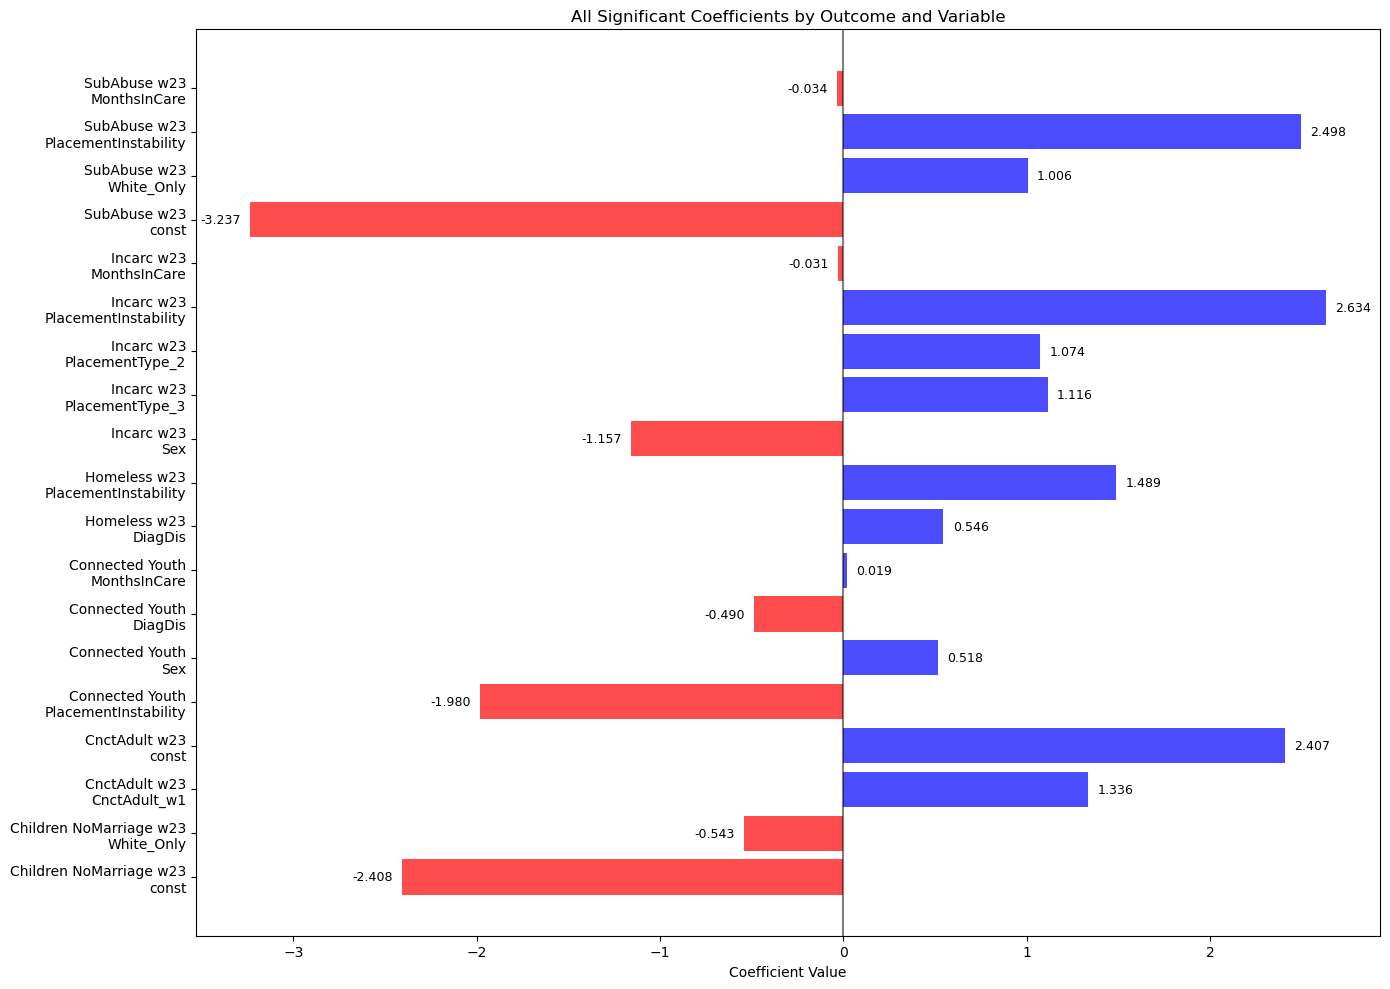

In [26]:
# Cell 5: Coefficient Magnitude Analysis
plt.figure(figsize=(14, 10))

# Create horizontal bar plot of all coefficients
y_pos = range(len(significant_model_results))
colors = ['red' if x < 0 else 'blue' for x in significant_model_results['Coefficient']]

plt.barh(y_pos, significant_model_results['Coefficient'], color=colors, alpha=0.7)

# Create labels with outcome and variable
labels = [f"{row['Outcome'].replace('_', ' ')}\n{row['Variable']}" 
          for _, row in significant_model_results.iterrows()]

plt.yticks(y_pos, labels, fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('All Significant Coefficients by Outcome and Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add coefficient values on bars
for i, (coef, outcome) in enumerate(zip(significant_model_results['Coefficient'], 
                                       significant_model_results['Outcome'])):
    offset = 0.05 if coef >= 0 else -0.05
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('Report/all_significant_coefficients_by_outcome_variable.png', bbox_inches='tight', dpi=300)
plt.show()

## How often it is present in a significant way

In [27]:
print("Columns in significant_model_results:")
for i, col in enumerate(significant_model_results.columns):
    print(f"{i+1}. {col}")

Columns in significant_model_results:
1. Outcome
2. Variable
3. Coefficient
4. P-Value
5. CI Lower
6. CI Upper
7. Significant


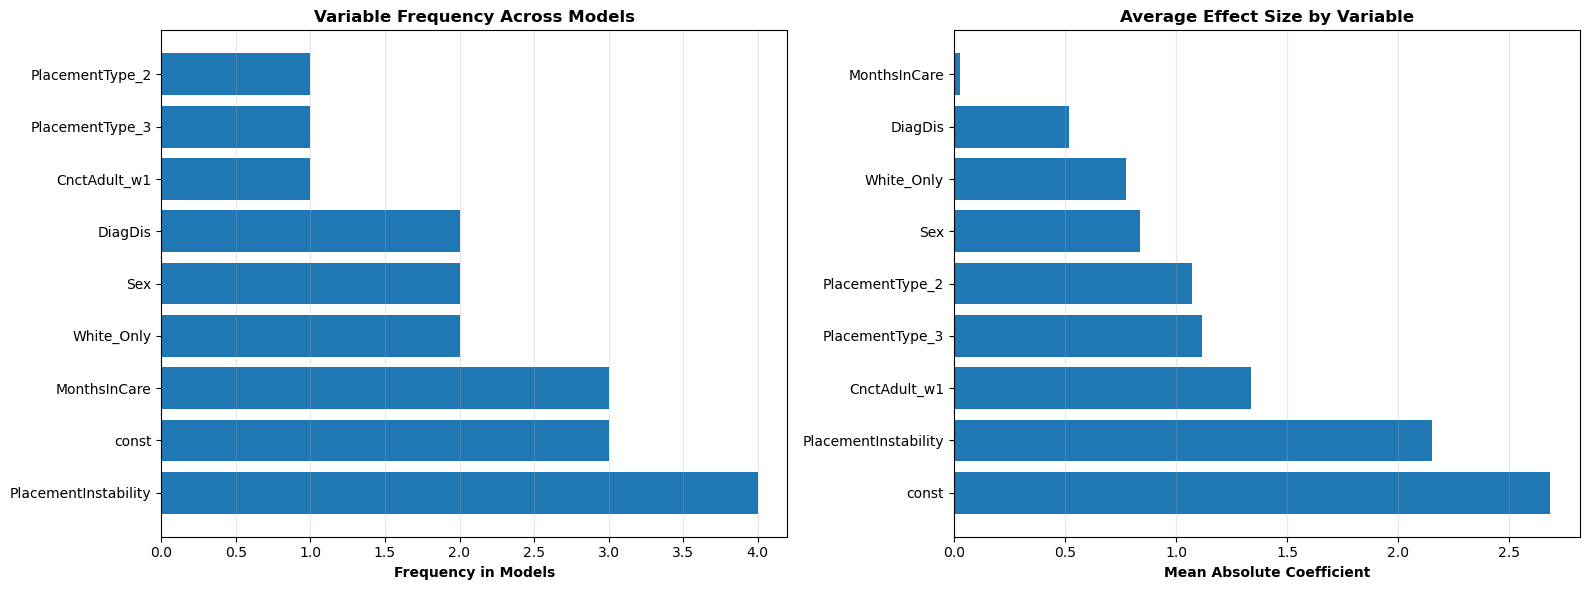


Variable Summary Statistics:
                      Frequency  Mean_Coeff  Std_Coeff  Mean_Abs_Coeff  \
Variable                                                                 
const                         3     -1.0794     3.0478          2.6842   
PlacementInstability          4      1.1603     2.1546          2.1501   
CnctAdult_w1                  1      1.3358        NaN          1.3358   
PlacementType_3               1      1.1163        NaN          1.1163   
PlacementType_2               1      1.0737        NaN          1.0737   
Sex                           2     -0.3197     1.1848          0.8378   
White_Only                    2      0.2318     1.0951          0.7744   
DiagDis                       2      0.0282     0.7325          0.5179   
MonthsInCare                  3     -0.0155     0.0299          0.0282   

                      Mean_P_Value  
Variable                            
const                       0.0210  
PlacementInstability        0.0159  
CnctAdu

In [28]:
# Cell 7: Variable Importance Analysis
# First, create the Abs_Coefficient column
significant_model_results['Abs_Coefficient'] = abs(significant_model_results['Coefficient'])

# Count how many times each variable appears and calculate average effect size
var_summary = significant_model_results.groupby('Variable').agg({
    'Coefficient': ['count', 'mean', 'std'],
    'Abs_Coefficient': 'mean',
    'P-Value': 'mean'
}).round(4)

var_summary.columns = ['Frequency', 'Mean_Coeff', 'Std_Coeff', 'Mean_Abs_Coeff', 'Mean_P_Value']
var_summary = var_summary.sort_values('Mean_Abs_Coeff', ascending=False)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Variable frequency
var_freq = significant_model_results['Variable'].value_counts()
ax1.barh(range(len(var_freq)), var_freq.values)
ax1.set_yticks(range(len(var_freq)))
ax1.set_yticklabels(var_freq.index)
ax1.set_xlabel('Frequency in Models', fontweight='bold')
ax1.set_title('Variable Frequency Across Models', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Average absolute effect size
ax2.barh(range(len(var_summary)), var_summary['Mean_Abs_Coeff'])
ax2.set_yticks(range(len(var_summary)))
ax2.set_yticklabels(var_summary.index)
ax2.set_xlabel('Mean Absolute Coefficient', fontweight='bold')
ax2.set_title('Average Effect Size by Variable', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Report/variable_importance_analysis.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nVariable Summary Statistics:")
print(var_summary)

## Outcome Bar charts

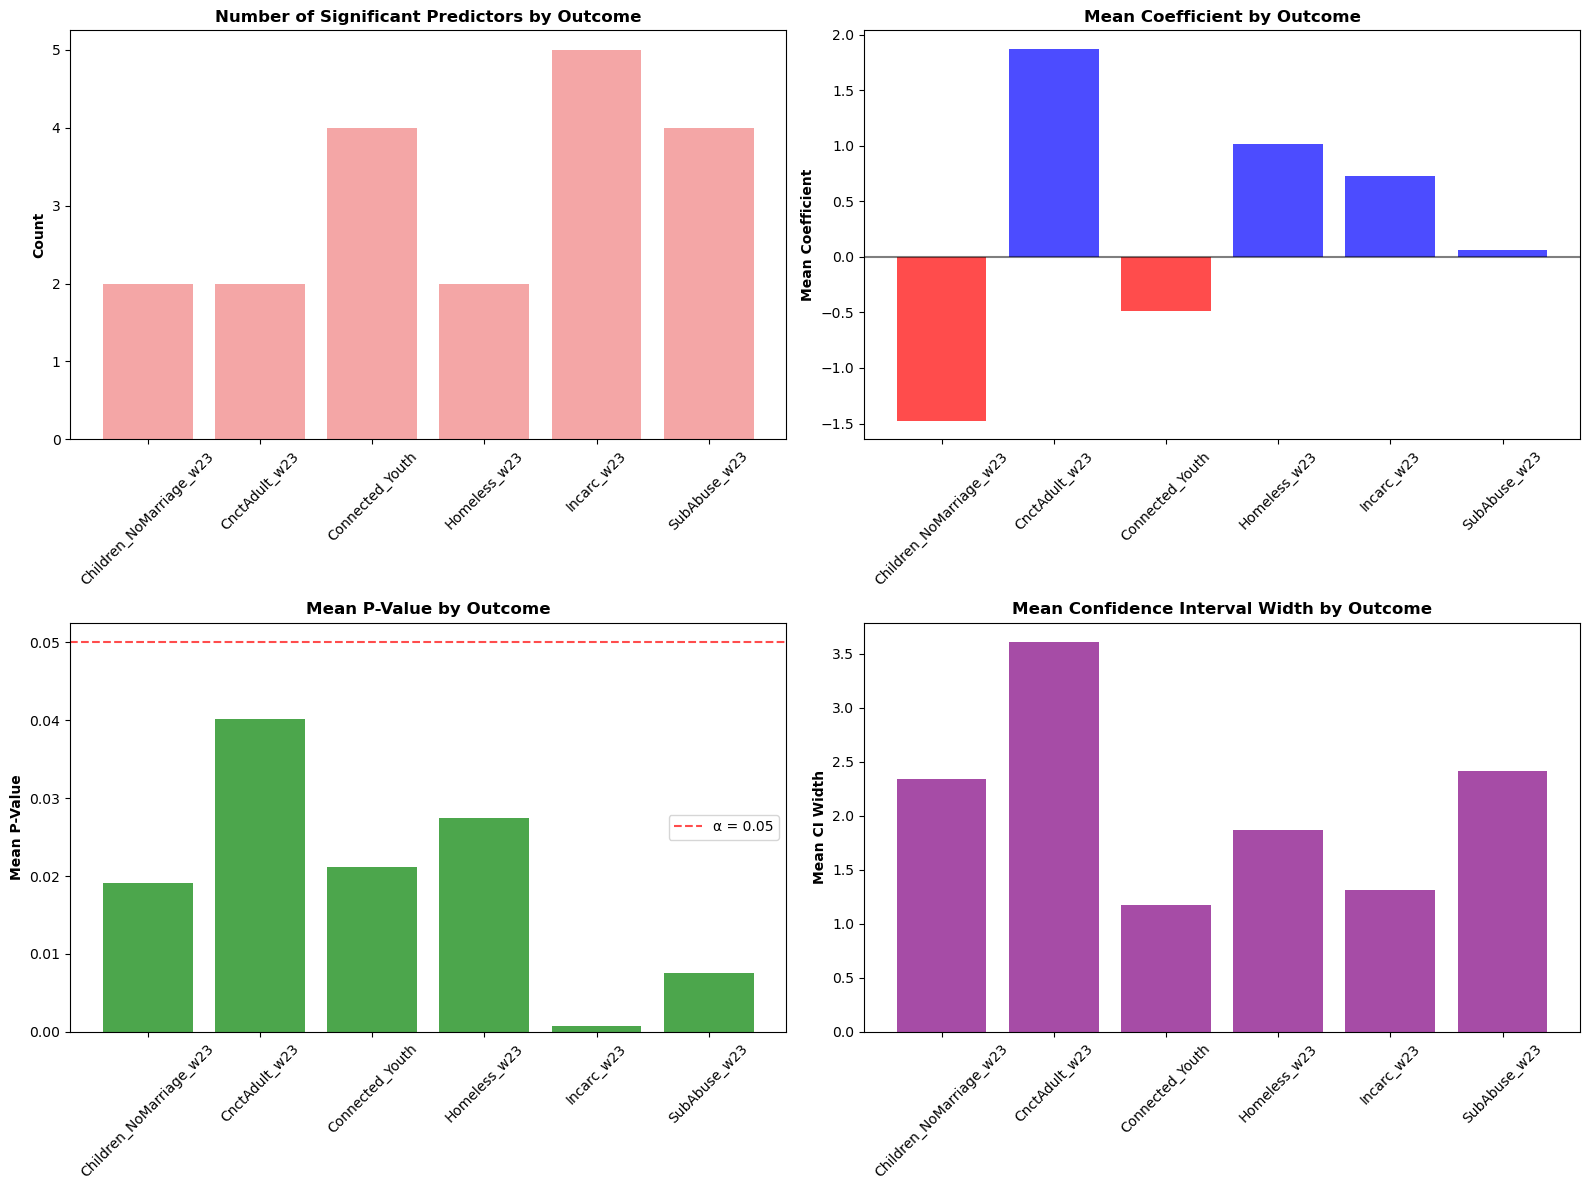


Outcome Summary Statistics:
                         N_Predictors  Mean_Coeff  Std_Coeff  Mean_P_Value  \
Outcome                                                                      
Children_NoMarriage_w23             2     -1.4753     1.3192        0.0191   
CnctAdult_w23                       2      1.8715     0.7576        0.0401   
Connected_Youth                     4     -0.4831     1.0792        0.0211   
Homeless_w23                        2      1.0176     0.6668        0.0274   
Incarc_w23                          5      0.7270     1.4172        0.0007   
SubAbuse_w23                        4      0.0582     2.4303        0.0075   

                         Mean_CI_Width  
Outcome                                 
Children_NoMarriage_w23         2.3444  
CnctAdult_w23                   3.6067  
Connected_Youth                 1.1755  
Homeless_w23                    1.8678  
Incarc_w23                      1.3116  
SubAbuse_w23                    2.4194  


In [29]:
# Cell 8: Outcome-Specific Analysis
# First, create the CI_Width column
significant_model_results['CI_Width'] = significant_model_results['CI Upper'] - significant_model_results['CI Lower']

# Number of significant predictors per outcome
outcome_summary = significant_model_results.groupby('Outcome').agg({
    'Variable': 'count',
    'Coefficient': ['mean', 'std'],
    'P-Value': 'mean',
    'CI_Width': 'mean'
}).round(4)

outcome_summary.columns = ['N_Predictors', 'Mean_Coeff', 'Std_Coeff', 'Mean_P_Value', 'Mean_CI_Width']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Number of predictors per outcome
ax1.bar(outcome_summary.index, outcome_summary['N_Predictors'], 
        color='lightcoral', alpha=0.7)
ax1.set_title('Number of Significant Predictors by Outcome', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Mean coefficient by outcome
colors = ['red' if x < 0 else 'blue' for x in outcome_summary['Mean_Coeff']]
ax2.bar(outcome_summary.index, outcome_summary['Mean_Coeff'], 
        color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_title('Mean Coefficient by Outcome', fontweight='bold')
ax2.set_ylabel('Mean Coefficient', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Mean p-value by outcome
ax3.bar(outcome_summary.index, outcome_summary['Mean_P_Value'], 
        color='green', alpha=0.7)
ax3.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
ax3.set_title('Mean P-Value by Outcome', fontweight='bold')
ax3.set_ylabel('Mean P-Value', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# Mean CI width by outcome
ax4.bar(outcome_summary.index, outcome_summary['Mean_CI_Width'], 
        color='purple', alpha=0.7)
ax4.set_title('Mean Confidence Interval Width by Outcome', fontweight='bold')
ax4.set_ylabel('Mean CI Width', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('Report/outcome_summary.png', bbox_inches='tight', dpi=300)
plt.show()

print("\nOutcome Summary Statistics:")
print(outcome_summary)

## Summary Dash

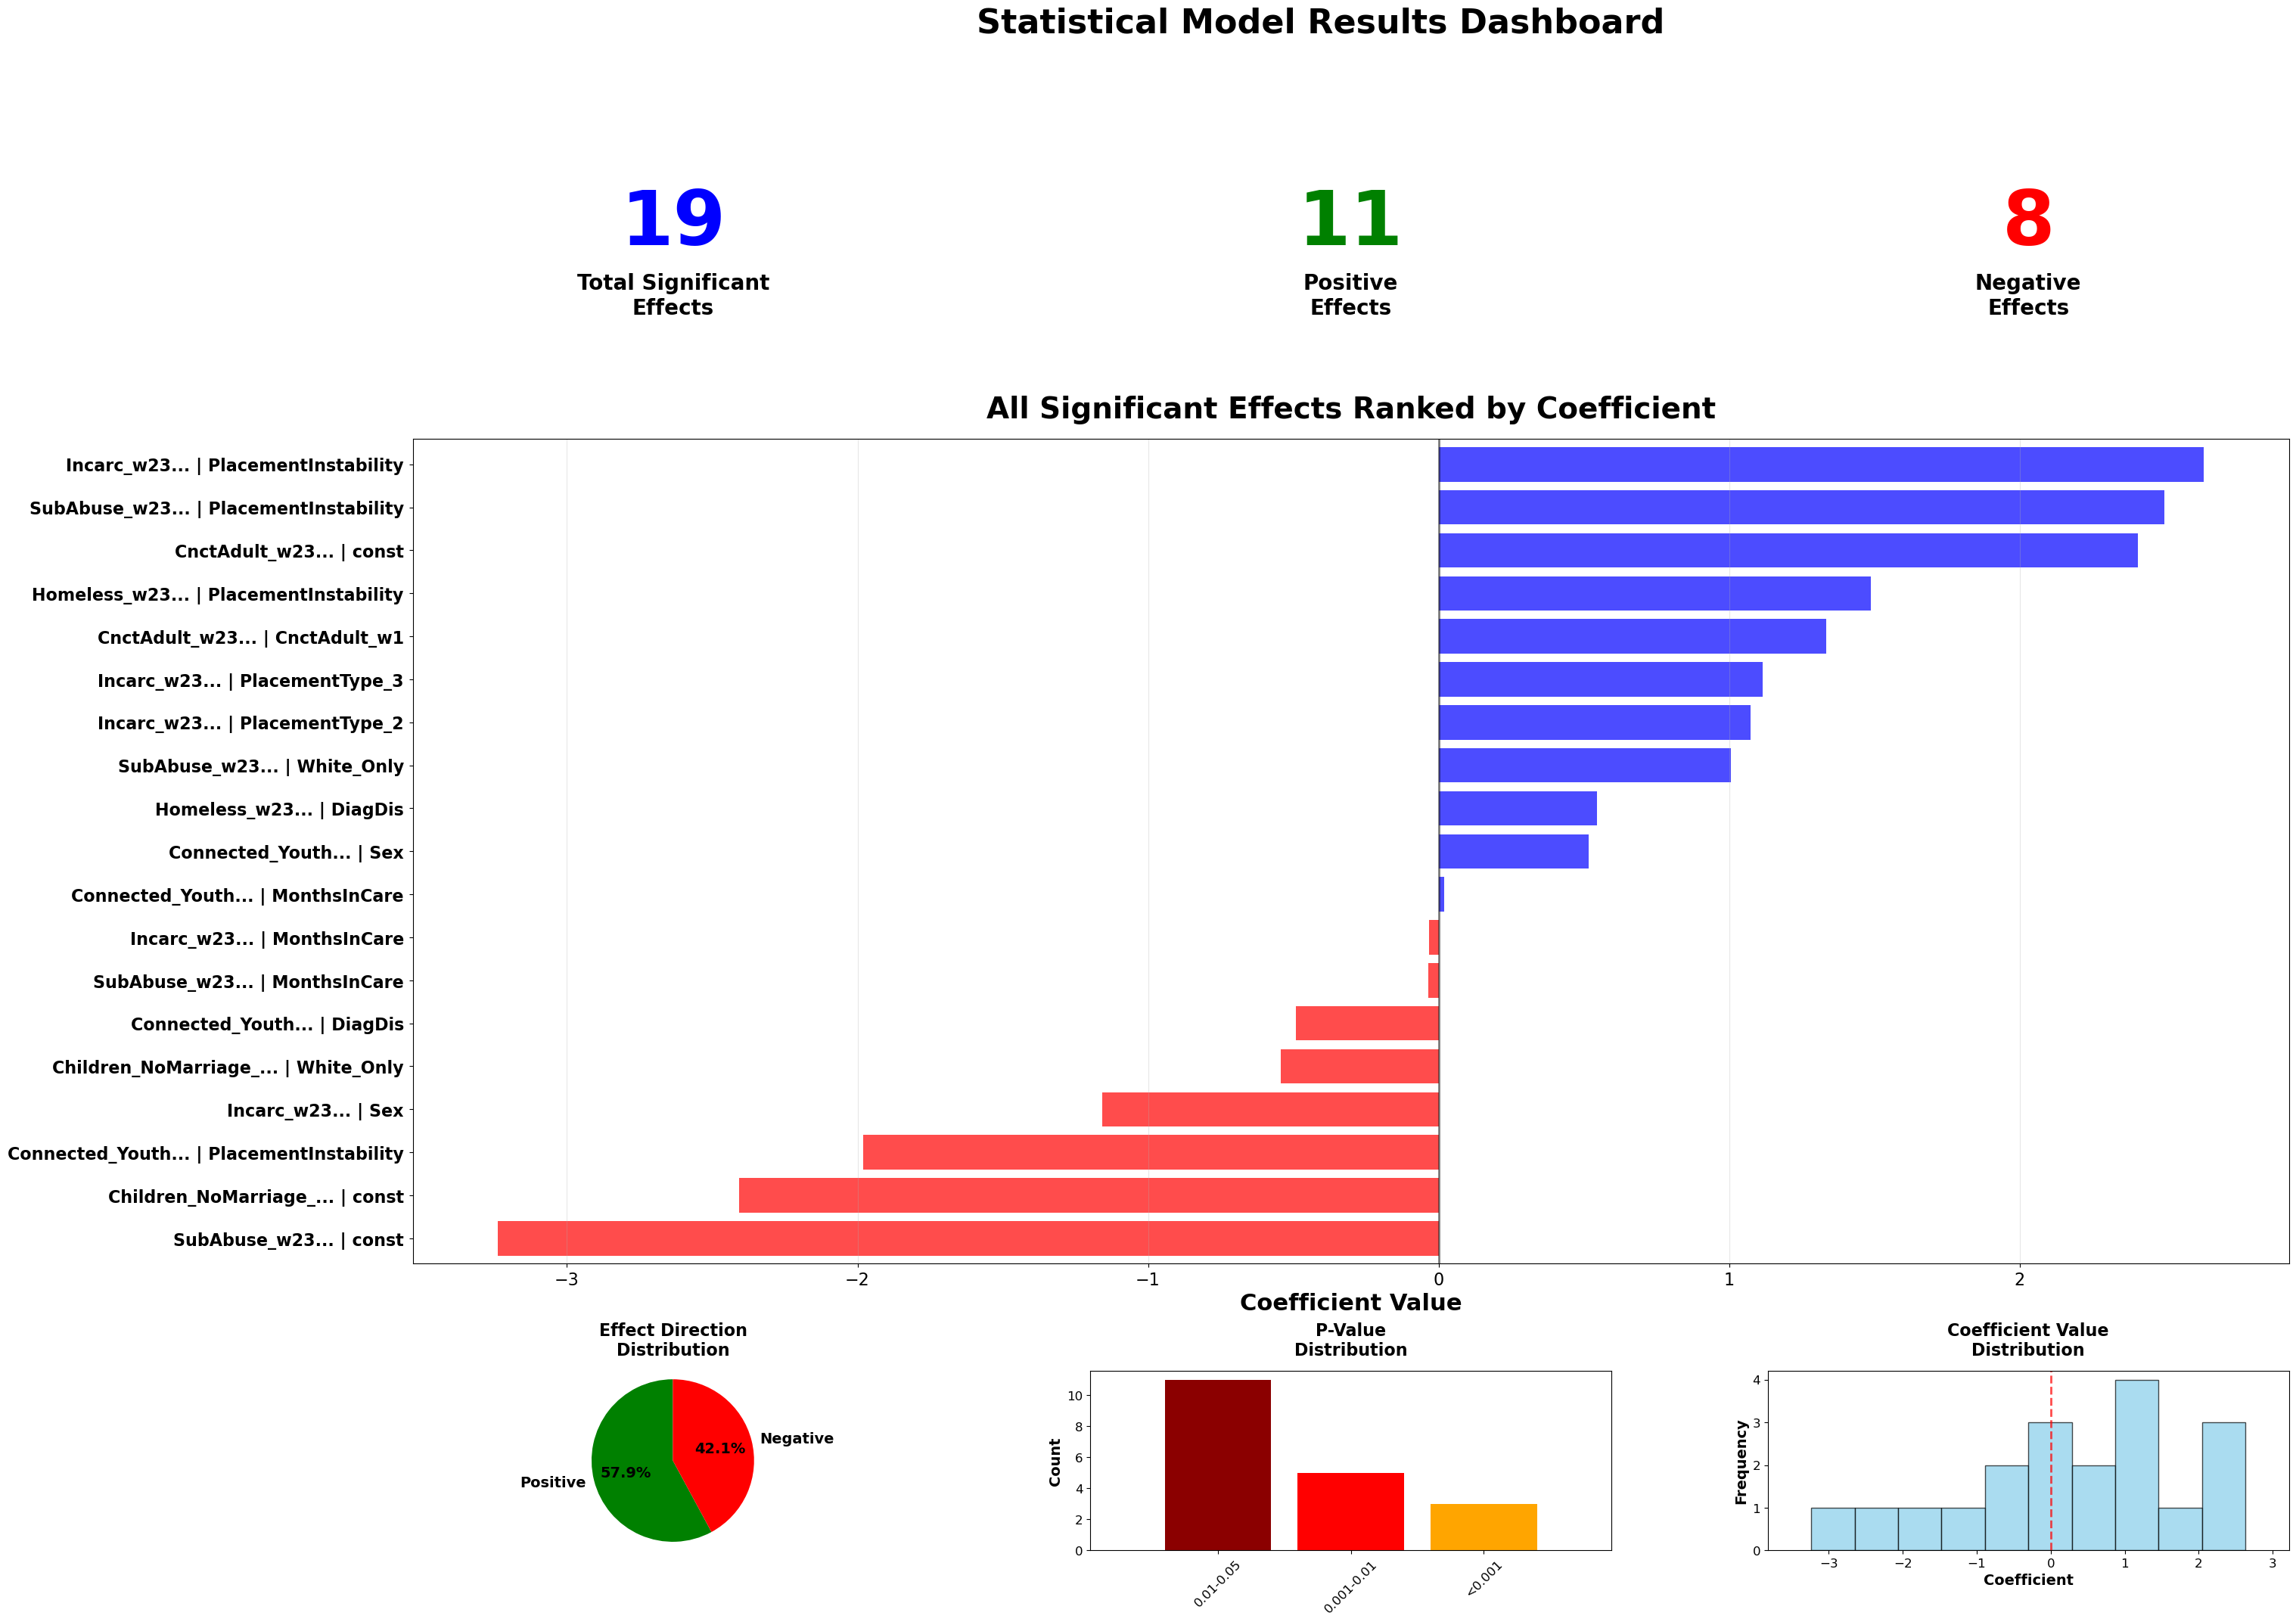

In [30]:
# Cell 9: Create Summary Dashboard
fig = plt.figure(figsize=(32, 24))  # Even bigger figure size

# Create a custom grid - giving much more space to the coefficient plot
gs = fig.add_gridspec(4, 3, height_ratios=[1, 3, 1, 1], hspace=0.4, wspace=0.3)

# Top row - Overview metrics
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Middle rows - Main coefficient visualization (spans 2 rows for more height)
ax4 = fig.add_subplot(gs[1:3, :])  # Takes up rows 1 and 2, full width

# Bottom row - Additional insights
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[3, 2])

# Key metrics
total_effects = len(significant_model_results)
positive_effects = (significant_model_results['Coefficient'] > 0).sum()
negative_effects = (significant_model_results['Coefficient'] < 0).sum()
mean_p_value = significant_model_results['P-Value'].mean()

# Metric boxes
metrics = [
    ('Total Significant\nEffects', total_effects, 'blue'),
    ('Positive\nEffects', positive_effects, 'green'),
    ('Negative\nEffects', negative_effects, 'red')
]

for i, (ax, (label, value, color)) in enumerate(zip([ax1, ax2, ax3], metrics)):
    ax.text(0.5, 0.6, str(value), ha='center', va='center', 
            fontsize=72, fontweight='bold', color=color)  # Increased from 48 to 72
    ax.text(0.5, 0.2, label, ha='center', va='center', 
            fontsize=20, fontweight='bold')  # Increased from 16 to 20
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Main coefficient plot (make y-labels much more visible)
df_sorted = significant_model_results.sort_values('Coefficient')
colors = ['red' if x < 0 else 'blue' for x in df_sorted['Coefficient']]

# Calculate proper spacing for y-axis
n_effects = len(df_sorted)
y_positions = range(n_effects)

bars = ax4.barh(y_positions, df_sorted['Coefficient'], color=colors, alpha=0.7, height=0.8)

ax4.set_yticks(y_positions)
# IMPROVED: Better label formatting with more space and cleaner text
ax4.set_yticklabels(
    [f"{row['Outcome'][:20]}... | {row['Variable'][:25]}" for _, row in df_sorted.iterrows()],
    fontsize=16, fontweight='bold'  # Increased from 14 to 16
)

ax4.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=2)
ax4.set_xlabel('Coefficient Value', fontweight='bold', fontsize=22)  # Increased from 18 to 22
ax4.set_title('All Significant Effects Ranked by Coefficient', fontweight='bold', fontsize=28, pad=20)  # Increased from 24 to 28
ax4.grid(axis='x', alpha=0.3)
ax4.tick_params(axis='y', labelsize=16, pad=5)  # Increased from 14 to 16
ax4.tick_params(axis='x', labelsize=16)  # Increased from 14 to 16

# Ensure all labels are visible by adjusting the plot area
ax4.margins(y=0.01)  # Small margin to ensure all bars are visible

# Effect direction pie chart
effect_direction = ['Positive' if x > 0 else 'Negative' for x in significant_model_results['Coefficient']]
direction_counts = pd.Series(effect_direction).value_counts()
ax5.pie(direction_counts.values, labels=direction_counts.index, autopct='%1.1f%%',
        colors=['green', 'red'], startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})  # Added larger text
ax5.set_title('Effect Direction\nDistribution', fontweight='bold', fontsize=16, pad=15)  # Added padding
ax5.axis('equal')  # Ensure pie chart is circular and centered

# P-value ranges
p_ranges = pd.cut(significant_model_results['P-Value'], bins=[0, 0.001, 0.01, 0.05], 
                  labels=['<0.001', '0.001-0.01', '0.01-0.05'])
p_counts = p_ranges.value_counts()
bars = ax6.bar(p_counts.index, p_counts.values, color=['darkred', 'red', 'orange'])
ax6.set_title('P-Value\nDistribution', fontweight='bold', fontsize=16, pad=15)  # Added padding
ax6.set_ylabel('Count', fontweight='bold', fontsize=14)
ax6.tick_params(axis='x', rotation=45, labelsize=12)
ax6.tick_params(axis='y', labelsize=12)
# Center the bars by adjusting margins
ax6.margins(x=0.2)  # Add margins to center the bars

# Coefficient range distribution
n, bins, patches = ax7.hist(significant_model_results['Coefficient'], bins=10, color='skyblue', alpha=0.7, edgecolor='black')
ax7.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)  # Thicker line
ax7.set_title('Coefficient Value\nDistribution', fontweight='bold', fontsize=16, pad=15)  # Added padding
ax7.set_xlabel('Coefficient', fontweight='bold', fontsize=14)
ax7.set_ylabel('Frequency', fontweight='bold', fontsize=14)
ax7.tick_params(axis='both', labelsize=12)
# Center the histogram by adjusting margins
ax7.margins(x=0.1)  # Add margins to center the histogram

plt.suptitle('Statistical Model Results Dashboard', fontsize=32, fontweight='bold', y=0.96)  # Increased from 28 to 32
fig.savefig('Report/summary_dashboard.png', bbox_inches='tight', dpi=300)
plt.show()

## Effect for specific Outcome

In [31]:
df = significant_model_results.copy()

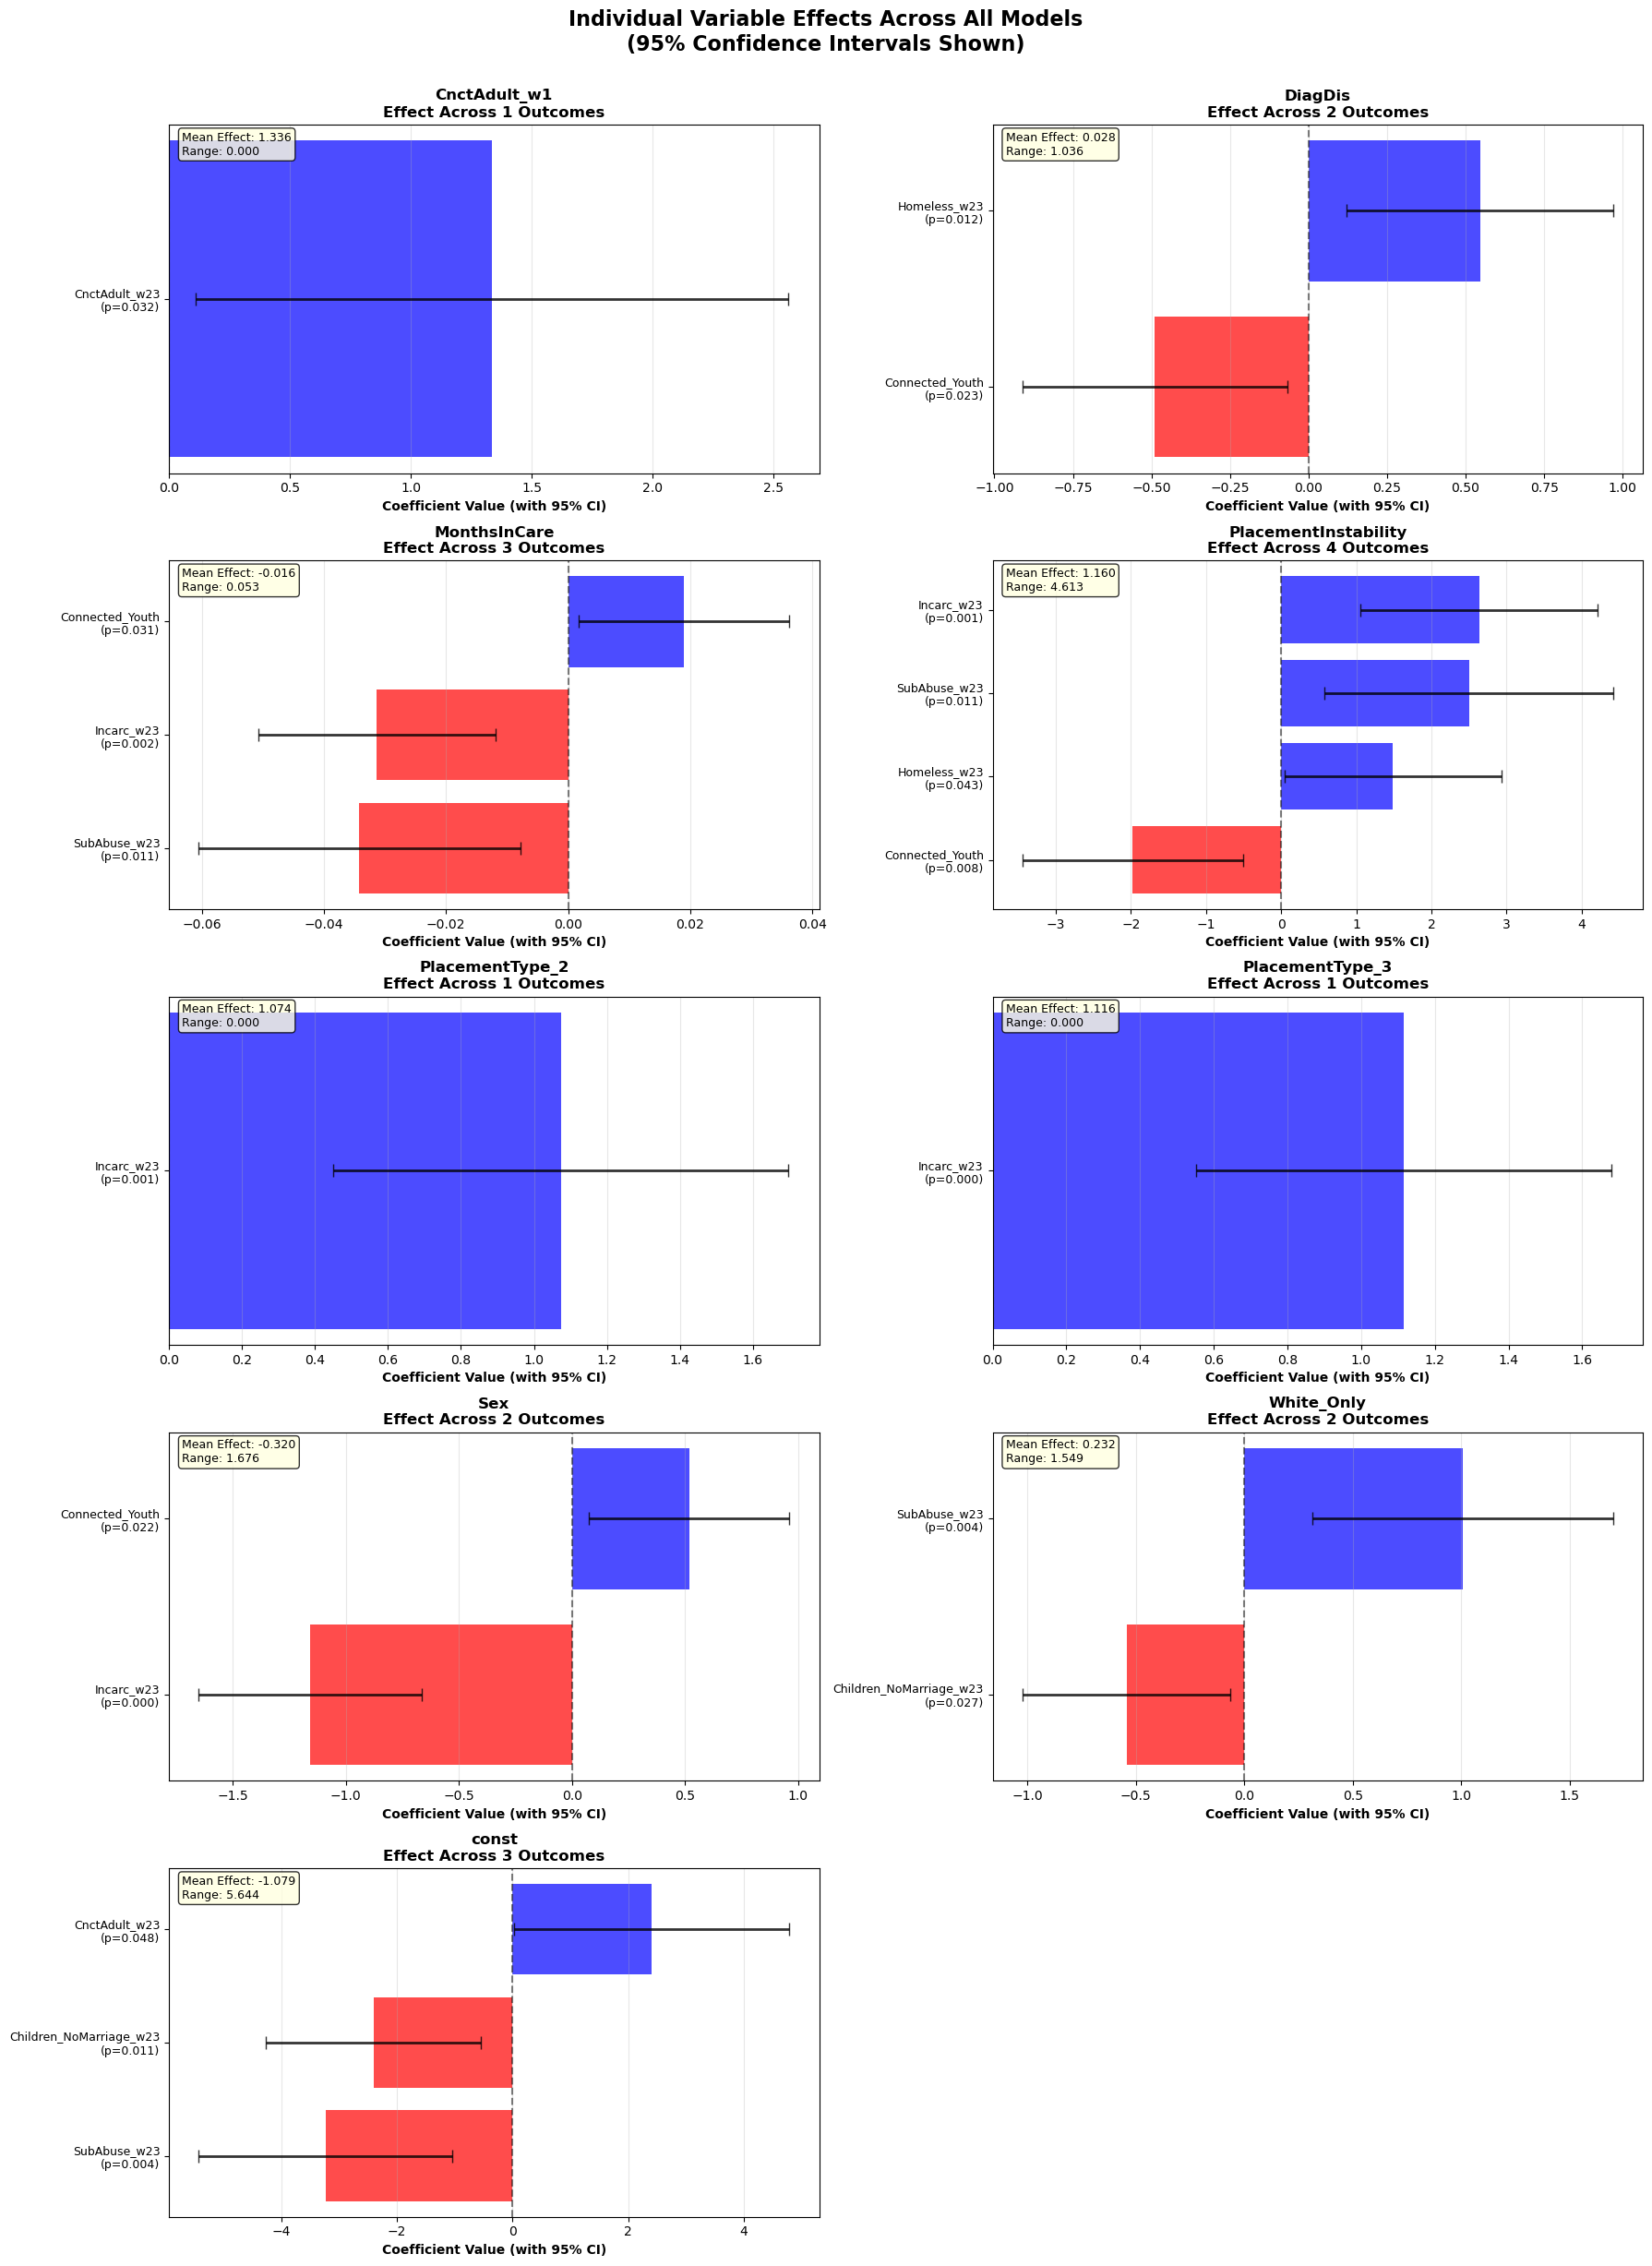

In [32]:
# Cell 4: Individual Variable Deep Dive Plots
def create_individual_variable_plots():
    variables = sorted(df['Variable'].unique())
    
    # Calculate number of rows needed (2 plots per row)
    n_rows = (len(variables) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5*n_rows))
    
    # Flatten axes if multiple rows
    if n_rows > 1:
        axes = axes.flatten()
    elif n_rows == 1:
        axes = [axes[0], axes[1]]
    
    for i, variable in enumerate(variables):
        if i >= len(axes):
            break
            
        ax = axes[i]
        var_data = df[df['Variable'] == variable].copy()
        
        if len(var_data) == 0:
            ax.text(0.5, 0.5, f'No data for {variable}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{variable}', fontweight='bold')
            continue
        
        # Sort by coefficient for better visualization
        var_data = var_data.sort_values('Coefficient')
        
        # Create horizontal bar plot with error bars
        y_pos = range(len(var_data))
        coeffs = var_data['Coefficient'].values
        
        # Calculate error bar lengths
        lower_errors = coeffs - var_data['CI Lower'].values
        upper_errors = var_data['CI Upper'].values - coeffs
        
        # Color bars by direction
        colors = ['red' if x < 0 else 'blue' for x in coeffs]
        
        # Create bars
        bars = ax.barh(y_pos, coeffs, color=colors, alpha=0.7, 
                      xerr=[lower_errors, upper_errors], 
                      capsize=5, error_kw={'linewidth': 2, 'alpha': 0.8})
        
        # Add outcome labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{row['Outcome']}\n(p={row['P-Value']:.3f})" 
                           for _, row in var_data.iterrows()], fontsize=9)
        
        # Add vertical line at zero
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
        # Customize
        ax.set_xlabel('Coefficient Value (with 95% CI)', fontweight='bold')
        ax.set_title(f'{variable}\nEffect Across {len(var_data)} Outcomes', 
                    fontweight='bold', fontsize=12)
        ax.grid(axis='x', alpha=0.3)
        
        # Add effect size summary
        mean_effect = var_data['Coefficient'].mean()
        effect_range = var_data['Coefficient'].max() - var_data['Coefficient'].min()
        
        ax.text(0.02, 0.98, f'Mean Effect: {mean_effect:.3f}\nRange: {effect_range:.3f}', 
               transform=ax.transAxes, va='top', ha='left', fontsize=9,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow', alpha=0.8))
    
    # Hide empty subplots
    for i in range(len(variables), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Individual Variable Effects Across All Models\n(95% Confidence Intervals Shown)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig('Report/individual_variable_effects.png', bbox_inches='tight', dpi=300)
    plt.show()

create_individual_variable_plots()

# Outcomes

In [33]:


# Key positive outcomes
positive_outcomes = [
    'CurrFTE_w23', 'HS_or_GED_w23', 'Assoc_Degree_w23', 'Bach_Degree_w23',
    'Higher_Degree_w23', 'Voc_Certificate_w23', 'Voc_License_w23', 'CnctAdult_w23',
    'PostSecEd_or_FTE'
]

# Key risk outcomes (to predict/prevent)
risk_outcomes = [
    'Homeless_w23', 'SubAbuse_w23', 'Incarc_w23', 'PubFinAs_w23', 'PubFoodAs_w23', 'PubHousAs_w23'
]
# Education outcomes
education_outcomes = [
    'HS_or_GED_w23', 'Voc_Certificate_w23', 'Voc_License_w23', 'Assoc_Degree_w23',
    'Bach_Degree_w23', 'Higher_Degree_w23', 'CurrenRoll_w23', 'PostSecEd_or_FTE'
]

# Employment outcomes
employment_outcomes = [
    'CurrFTE_w23', 'CurrPTE_w23', 'EmplySklls_w23', 'PostSecEd_or_FTE'
]
# Housing/stability outcomes
housing_outcomes = [
    'Homeless_w23', 'PubHousAs_w23', 'PubFinAs_w23', 'PubFoodAs_w23', 'SocSecrty_w23'
]

# Predictors

In [34]:
# Demographics
demographics_predictors = [
    'Sex', 'White_Only', 'Black_Only', 'race_other'
]
# Foster care experience
care_history_predictors = [
    'MonthsInCare', 'PlacementType', 'PlacementInstability', 'Service_Count'
]

# Maltreatment history
maltreatment_history_predictors = [
    'RR_neglect', 'RR_abuse', 'RR_other'
]

# Disabilities
disabilitie_predictors = [
    'DiagDis'
]

# Baseline

In [35]:
# All baseline (w1) predictors
all_baseline_w1 = [
    'OutcmFCS_w1', 'CurrFTE_w1', 'CurrPTE_w1', 'EmplySklls_w1', 'SocSecrty_w1',
    'EducAid_w1', 'PubFinAs_w1', 'PubFoodAs_w1', 'PubHousAs_w1', 'OthrFinAs_w1',
    'CurrenRoll_w1', 'CnctAdult_w1', 'Homeless_w1', 'SubAbuse_w1', 'Incarc_w1',
    'Children_w1', 'Marriage_w1', 'Medicaid_w1', 'OthrHlthIn_w1', 'MedicalIn_w1',
    'MentlHlthIn_w1', 'PrescripIn_w1', 'Baseline_w1', 'Elig19_w1', 'Elig21_w1',
    'Responded_w1', 'HS_or_GED_w1', 'Voc_Certificate_w1', 'Voc_License_w1',
    'Assoc_Degree_w1', 'Bach_Degree_w1', 'Higher_Degree_w1'
]
# Housing baseline predictors
housing_baseline = [
    'Homeless_w1', 'PubHousAs_w1', 'PubFinAs_w1', 'PubFoodAs_w1', 'SocSecrty_w1'
]
# Risk baseline predictors
risk_baseline = [
    'SubAbuse_w1', 'Incarc_w1', 'RR_neglect', 'RR_abuse', 'RR_other'
]
# Employment baseline
employment_baseline = [
    'CurrFTE_w1', 'CurrPTE_w1', 'EmplySklls_w1'
]
# Education baseline predictors
education_baseline = [
    'HS_or_GED_w1', 'Voc_Certificate_w1', 'Voc_License_w1', 'Assoc_Degree_w1',
    'Bach_Degree_w1', 'Higher_Degree_w1', 'CurrenRoll_w1'
]


In [36]:
# All follow-up outcomes (age 19-21)
all_outcomes_w23 = [
    'OutcmRpt_w23', 'OutcmFCS_w23', 'CurrFTE_w23', 'CurrPTE_w23', 'EmplySklls_w23',
    'SocSecrty_w23', 'EducAid_w23', 'PubFinAs_w23', 'PubFoodAs_w23', 'PubHousAs_w23',
    'OthrFinAs_w23', 'CurrenRoll_w23', 'CnctAdult_w23', 'Homeless_w23', 'SubAbuse_w23',
    'Incarc_w23', 'Children_w23', 'Marriage_w23', 'Medicaid_w23', 'OthrHlthIn_w23',
    'MedicalIn_w23', 'MentlHlthIn_w23', 'PrescripIn_w23', 'Elig19_w23', 'Elig21_w23',
    'Responded_w23', 'HS_or_GED_w23', 'Voc_Certificate_w23', 'Voc_License_w23',
    'Assoc_Degree_w23', 'Bach_Degree_w23', 'Higher_Degree_w23'
]

predictor_groups = {
    'Core': demographics_predictors,
    'Disability': disabilitie_predictors,
    'Placement': ['PlacementType', 'PlacementInstability', 'MonthsInCare'],
    'CareHistory': care_history_predictors,
    'MaltreatmentHistory': maltreatment_history_predictors,
    'EarlyIndicators': ['SubAbuse_w1', 'CnctAdult_w1']
}

In [37]:
wave_service_afcars['PubFinAs_w23'] = pd.to_numeric(wave_service_afcars['PubFinAs_w23'], errors='coerce').astype('Int64')  

In [38]:
all_results = []
significant_results = []

for outcome in all_outcomes_w23:
    predictors = sum(predictor_groups.values(), [])  # flatten all predictor lists
    model_vars = predictors + [outcome]

    df_model = wave_service_afcars[model_vars].copy()
    df_model = df_model.replace([np.inf, -np.inf], np.nan)
    df_model = df_model.apply(pd.to_numeric, errors='coerce').dropna()

    if df_model.shape[0] < 10:
        print(f"⏭️ Skipped: {outcome} — Too few rows ({df_model.shape[0]}) after cleaning")
        continue

    y = df_model[outcome].astype(int)

    # Check if y has both classes
    if len(y.unique()) < 2:
        print(f"⏭️ Skipped: {outcome} — Only one class present: {y.unique()[0]}")
        continue

    X = df_model.drop(columns=[outcome])

    # Drop constant columns
    X = X.loc[:, X.nunique() > 1]

    # Drop highly correlated columns
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.99)]
    X = X.drop(columns=to_drop)

    # Add constant
    X = sm.add_constant(X, has_constant='add')

    # Check if matrix is too wide
    if X.shape[0] <= X.shape[1]:
        print(f"⏭️ Skipped: {outcome} — Too few rows ({X.shape[0]}) for number of predictors ({X.shape[1]})")
        continue

    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=False)

        pvals = result.pvalues
        conf = result.conf_int()
        summary_df = pd.DataFrame({
            'Outcome': outcome,
            'Variable': pvals.index,
            'Coefficient': result.params,
            'P-Value': pvals,
            'CI Lower': conf[0],
            'CI Upper': conf[1]
        })

        summary_df['Significant'] = summary_df['P-Value'] < 0.05
        all_results.append(summary_df)

        sig_only = summary_df[summary_df['Significant']]
        if not sig_only.empty:
            significant_results.append(sig_only)

        print(f"✅ Model completed for outcome: {outcome}")

    except Exception as e:
        print(f"❌ Model failed for outcome: {outcome} — {e}")


⏭️ Skipped: OutcmRpt_w23 — Only one class present: 1
✅ Model completed for outcome: OutcmFCS_w23
✅ Model completed for outcome: CurrFTE_w23
✅ Model completed for outcome: CurrPTE_w23
✅ Model completed for outcome: EmplySklls_w23
✅ Model completed for outcome: SocSecrty_w23
✅ Model completed for outcome: EducAid_w23
❌ Model failed for outcome: PubFinAs_w23 — Singular matrix
✅ Model completed for outcome: PubFoodAs_w23
✅ Model completed for outcome: PubHousAs_w23
✅ Model completed for outcome: OthrFinAs_w23


c:\Users\emros\anaconda4\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

✅ Model completed for outcome: CurrenRoll_w23
✅ Model completed for outcome: CnctAdult_w23
✅ Model completed for outcome: Homeless_w23
✅ Model completed for outcome: SubAbuse_w23
✅ Model completed for outcome: Incarc_w23
✅ Model completed for outcome: Children_w23
✅ Model completed for outcome: Marriage_w23


c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Model completed for outcome: Medicaid_w23
✅ Model completed for outcome: OthrHlthIn_w23
⏭️ Skipped: MedicalIn_w23 — Only one class present: 1


c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood 

❌ Model failed for outcome: MentlHlthIn_w23 — Singular matrix
⏭️ Skipped: PrescripIn_w23 — Only one class present: 1
✅ Model completed for outcome: Elig19_w23
⏭️ Skipped: Elig21_w23 — Only one class present: 1
✅ Model completed for outcome: Responded_w23
✅ Model completed for outcome: HS_or_GED_w23
⏭️ Skipped: Voc_Certificate_w23 — Only one class present: 0
⏭️ Skipped: Voc_License_w23 — Only one class present: 0
✅ Model completed for outcome: Assoc_Degree_w23
⏭️ Skipped: Bach_Degree_w23 — Only one class present: 0
⏭️ Skipped: Higher_Degree_w23 — Only one class present: 0


c:\Users\emros\anaconda4\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
# Step 5: VIF calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Output
print("📊 Variance Inflation Factors Model 3:")
print(vif_data)

📊 Variance Inflation Factors Model 3:
          feature        VIF
0           const  39.240059
1             Sex   1.058932
2      White_Only   1.169984
3      race_other   1.136593
4         DiagDis   1.031353
5   Service_Count   1.023326
6      RR_neglect   1.310515
7        RR_abuse   1.519370
8        RR_other   1.758688
9     SubAbuse_w1   1.064421
10   CnctAdult_w1   1.069263


In [40]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_scaled = sm.add_constant(X_scaled, has_constant='add')

In [42]:
model = sm.Logit(y, X_scaled)

In [43]:
# Combine results across all models
more_results_df = pd.concat(all_results, ignore_index=True)



# Show top significant results
print("📊 Top Significant Predictors (p < 0.05):")
display(more_results_df.head(10))



📊 Top Significant Predictors (p < 0.05):


,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
0,OutcmFCS_w23,const,-1.330804,0.196900,-3.352084,0.690476,False
1,OutcmFCS_w23,Sex,-0.093837,0.780314,-0.753254,0.565579,False
2,OutcmFCS_w23,White_Only,0.151025,0.680869,-0.568692,0.870742,False
3,OutcmFCS_w23,race_other,1.444316,0.086511,-0.207168,3.095800,False
4,OutcmFCS_w23,DiagDis,-1.157035,0.001027,-1.847791,-0.466279,True
5,OutcmFCS_w23,Service_Count,0.833259,0.002302,0.297488,1.369031,True
6,OutcmFCS_w23,RR_neglect,0.747796,0.105877,-0.158603,1.654194,False
7,OutcmFCS_w23,RR_abuse,0.071975,0.905877,-1.121078,1.265027,False
8,OutcmFCS_w23,RR_other,1.053022,0.078075,-0.118333,2.224377,False
9,OutcmFCS_w23,SubAbuse_w1,-0.674786,0.094620,-1.466017,0.116446,False


In [44]:
# Combine results across all models
more_sig_results_df = pd.concat(significant_results, ignore_index=True)



# Show top significant results
print("📊 Top Significant Predictors (p < 0.05):")
display(more_sig_results_df.head(10))



📊 Top Significant Predictors (p < 0.05):


,Outcome,Variable,Coefficient,P-Value,CI Lower,CI Upper,Significant
0,OutcmFCS_w23,DiagDis,-1.157035,0.001027,-1.847791,-0.466279,True
1,OutcmFCS_w23,Service_Count,0.833259,0.002302,0.297488,1.369031,True
2,EducAid_w23,Service_Count,0.535932,0.020589,0.082276,0.989588,True
3,PubFoodAs_w23,const,-3.565473,0.012401,-6.360181,-0.770766,True
4,PubFoodAs_w23,Sex,1.774532,0.000190,0.842582,2.706481,True
5,CurrenRoll_w23,DiagDis,-0.921065,0.008258,-1.604532,-0.237597,True
6,CurrenRoll_w23,Service_Count,0.692286,0.012955,0.146266,1.238307,True
7,Homeless_w23,DiagDis,0.853566,0.025443,0.104905,1.602227,True
8,Homeless_w23,RR_other,-1.724552,0.016188,-3.130191,-0.318912,True
9,OthrHlthIn_w23,const,-3.553435,0.029789,-6.758667,-0.348202,True


In [45]:
print(more_sig_results_df.shape)

(17, 7)


In [46]:
more_sig_results_df.to_csv('more_sig_results_df.csv', index=False)
more_results_df.to_csv('more_results_df.csv', index=False)

In [47]:
more_sig_results_df = pd.read_csv('more_sig_results_df.csv')
more_results_df = pd.read_csv('more_results_df.csv')

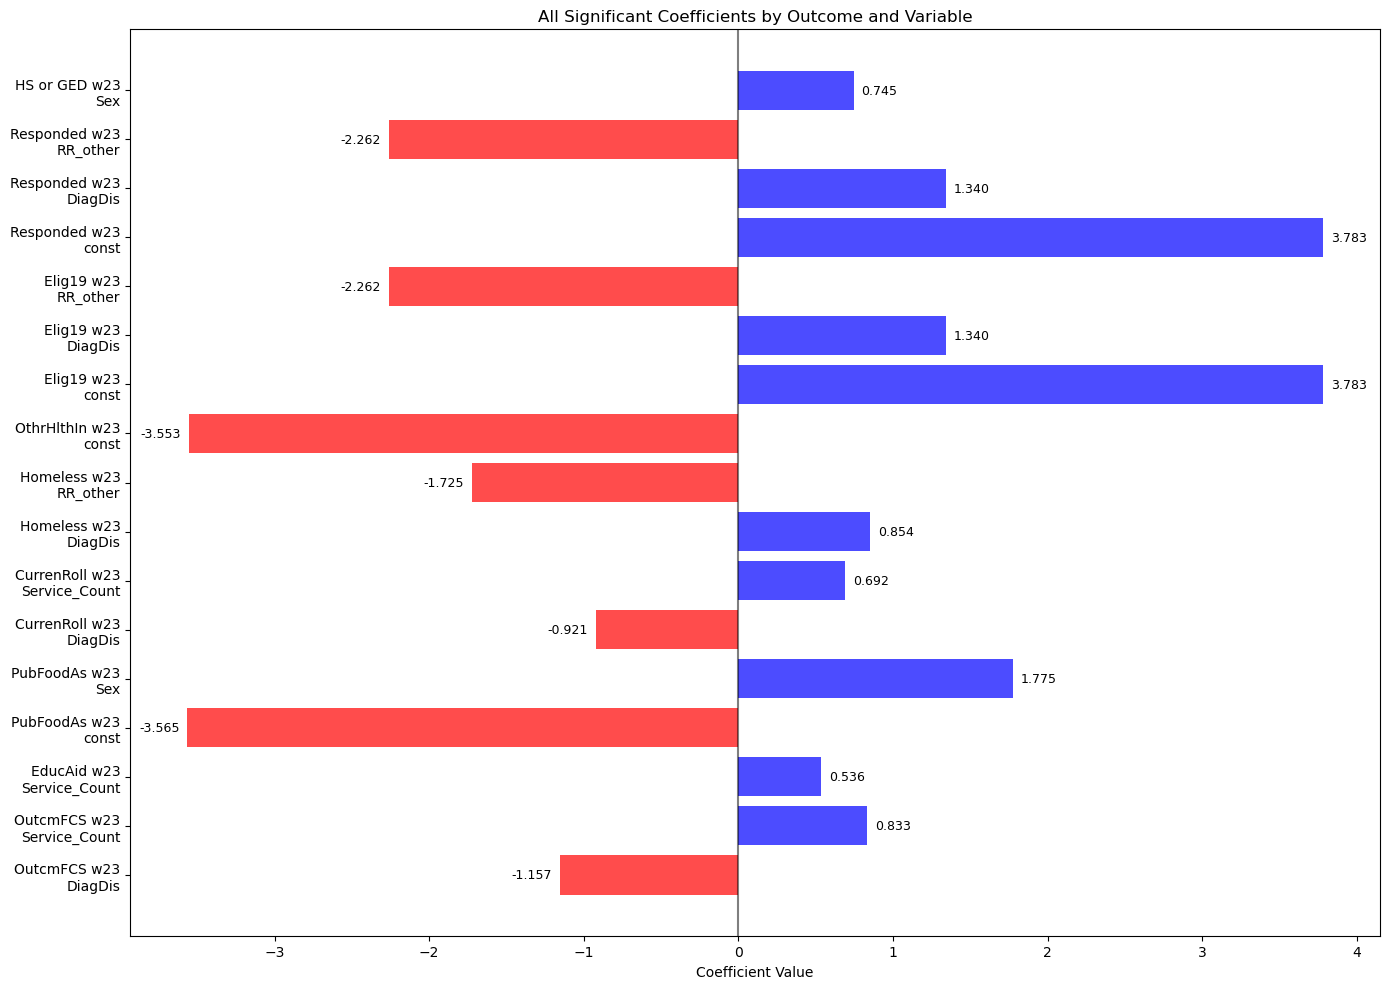

In [48]:
# Cell 5: Coefficient Magnitude Analysis
plt.figure(figsize=(14, 10))

# Create horizontal bar plot of all coefficients
y_pos = range(len(more_sig_results_df))
colors = ['red' if x < 0 else 'blue' for x in more_sig_results_df['Coefficient']]

plt.barh(y_pos, more_sig_results_df['Coefficient'], color=colors, alpha=0.7)

# Create labels with outcome and variable
labels = [f"{row['Outcome'].replace('_', ' ')}\n{row['Variable']}" 
          for _, row in more_sig_results_df.iterrows()]

plt.yticks(y_pos, labels, fontsize=10)
plt.xlabel('Coefficient Value')
plt.title('All Significant Coefficients by Outcome and Variable')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add coefficient values on bars
for i, (coef, outcome) in enumerate(zip(more_sig_results_df['Coefficient'], 
                                       more_sig_results_df['Outcome'])):
    offset = 0.05 if coef >= 0 else -0.05
    ha = 'left' if coef >= 0 else 'right'
    plt.text(coef + offset, i, f'{coef:.3f}', va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig('Report/ALL_more_sig_by_outcome.png', bbox_inches='tight', dpi=300)
plt.show()